# Particle Collision Classification using Support Vector Machines

# Introduction

This notebook explores the application of Support Vector Machines (SVM) to classify particle collisions from the HIGGS dataset. The dataset contains simulated collision events, with each event either being a signal process producing Higgs bosons (class 1) or a background process (class 0).

### Dataset Overview
The HIGGS dataset contains 28 features derived from particle physics measurements, including:
- Low-level features: Raw measurements like particle momentum (pT), pseudorapidity (eta), and azimuthal angle (phi)
- High-level features: Derived quantities like invariant masses of particle combinations

### SVM Classification Approach
We'll use Support Vector Machines with different kernel functions to classify these collision events:

- Linear kernel: For linearly separable data
- RBF (Gaussian) kernel: For non-linear decision boundaries
- Polynomial kernel: For capturing higher-order feature interactions
- Custom hybrid kernel: Combining multiple kernels to leverage different aspects of the data

The choice of kernel is crucial as it determines how the SVM algorithm maps the input features to a higher-dimensional space where the classes become separable. We'll experiment with various kernel parameters to optimize the classification performance.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif


### Reading the dataset

The dataset

The dataset HIGGs does not have the column headings, which means we need to set "header = None" so that we do not lose one data point when converting to pandas dataframe


In [3]:
# The following lines were used to unzip the dataset and convert to csv (need not be run again, as the current
# uploaded files has the smaller version of it)

# df = pd.read_csv('HIGGS.csv', header = None)
# df

# read only the target column of the dataset
# y_main = pd.read_csv('../HIGGS.csv', header = None, usecols=[0])
# y_main.columns = ['target']

In [4]:
# column_names = ['class',
#     'lepton_pT', 'lepton_eta', 'lepton_phi', 'missing_energy_magnitude', 'missing_energy_phi',
#     'jet_1_pt', 'jet_1_eta', 'jet_1_phi', 'jet_1_btag',
#     'jet_2_pt', 'jet_2_eta', 'jet_2_phi', 'jet_2_btag',
#     'jet_3_pt', 'jet_3_eta', 'jet_3_phi', 'jet_3_btag',
#     'jet_4_pt', 'jet_4_eta', 'jet_4_phi', 'jet_4_btag',
#     'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb'
# ]

# df.columns = column_names

# Exploratory Data Analysis and Preprocessing

### Dataset Sampling

\**Stratified Sampling* - Stratified random sampling is a method of sampling that involves the division of a population into smaller subgroups known as strata. In stratified random sampling, or stratification, the strata are formed based on members’ shared attributes or characteristics. Stratified sampling is used to highlight differences among groups in a population. This is different from simple random sampling, which treats all members of a population as equal, with an equal likelihood of being sampled.

In the following commented code (using which initially the entire HIGGS dataset was contracted to smaller 1% set), we first group the instances by class and within them, sample 1% of points (essentially what stratified sampling does).

In [5]:
# df = df.groupby('class').apply(lambda x: x.sample(frac=.01, random_state=42)).reset_index(drop = True)
# df.to_csv('HIGGS_smaller_updated.csv', index = False)

In [13]:
df = pd.read_csv('HIGGS_smaller_updated.csv')
df

,class,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_btag,...,jet_4_eta,jet_4_phi,jet_4_btag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,0.0,0.795907,0.521993,1.266055,1.193820,-1.345527,1.050368,0.023740,-0.202843,0.000000,...,1.112191,0.023700,0.000000,1.042175,1.027780,0.985253,0.817024,0.931846,0.893235,0.815815
1,0.0,0.439039,-0.246468,-1.633201,2.165616,-1.280181,1.113852,0.099988,0.030652,0.000000,...,1.272093,1.334957,3.101961,0.847423,1.107451,0.992869,0.645746,0.615797,1.053485,1.169667
2,0.0,0.792429,-0.225041,0.476488,0.216189,-0.653596,0.706933,-1.342777,1.307932,2.173076,...,-1.075636,-1.354807,3.101961,0.812245,0.768737,0.984995,0.809043,0.516027,0.810711,0.770562
3,0.0,2.508689,0.605754,0.057012,1.908093,0.369292,1.448035,1.172407,-1.662516,2.173076,...,1.333722,-1.187779,0.000000,0.483426,0.583755,0.980170,1.504814,0.745402,1.502971,1.080458
4,0.0,0.956040,-0.425679,0.380497,0.382192,1.287647,1.112112,1.256576,0.019010,2.173076,...,-1.447075,0.845525,0.000000,1.010567,1.105782,0.990340,1.734094,1.841294,1.493804,1.189773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109995,1.0,1.326267,-1.027591,-0.629456,1.147094,-0.038268,1.000717,-0.334723,1.111683,2.173076,...,0.176098,-0.395917,0.000000,0.471924,0.605922,0.988520,0.860052,1.002536,1.008905,0.764430
109996,1.0,0.534753,-1.201932,-0.766507,0.721336,-1.586289,0.814297,-0.636743,0.779613,0.000000,...,1.446986,0.315584,0.000000,0.903345,0.907817,0.989411,0.542765,0.531479,0.656743,0.770066
109997,1.0,0.524138,1.794970,0.293383,0.789934,1.561737,0.736888,1.280342,-0.677391,2.173076,...,2.052449,-0.951386,0.000000,0.932308,0.815919,0.987882,0.829535,0.607425,0.616863,0.606310
109998,1.0,0.971595,0.186948,-0.499616,1.675635,-0.546097,0.918546,-0.355518,1.199275,2.173076,...,0.028688,1.523072,0.000000,0.743745,0.679649,0.981990,1.026166,0.623709,1.111592,0.875511


### Constants

The section below sets all the constants that might be required in the notebook.

In [14]:
RANDOM_STATE = 42
y_col = "class"

### Quick Feature Analysis

Data Types

Verifying whether all the data points have numerical values (since the original data did not have header)


In [15]:
df.dtypes

,0
class,float64
lepton_pT,float64
lepton_eta,float64
lepton_phi,float64
missing_energy_magnitude,float64
missing_energy_phi,float64
jet_1_pt,float64
jet_1_eta,float64
jet_1_phi,float64
jet_1_btag,float64


#### Missing Value Analysis

None of the columns have missing values, hence no need to perform any data imputations

In [16]:
df.isna().sum()

,0
class,0
lepton_pT,0
lepton_eta,0
lepton_phi,0
missing_energy_magnitude,0
missing_energy_phi,0
jet_1_pt,0
jet_1_eta,0
jet_1_phi,0
jet_1_btag,0


#### Target Variable Analysis

Class with value 1 represents SIGNAL (53% of the data), and Class with value 0 represents BACKGROUND (47% of the data)

Looks like there is very little imbalance in data.

In [17]:
df[y_col].value_counts() / len(df)

,count
class,
1.0,0.529918
0.0,0.470082


#### Simple Statistcal Analysis

Using the `describe` function we can see some simple statistics of all the columns. Given there are so many columns, it is hard to see understand the distrubtion and what each columns represent. Hence we will then move to plots to understand better.

In [18]:
df.describe()

,class,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_btag,...,jet_4_eta,jet_4_phi,jet_4_btag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
count,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,...,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000
mean,0.529918,0.990136,-0.005788,0.001553,1.000278,0.001863,0.990156,0.001501,-0.003962,1.001442,...,0.000049,0.000948,1.001539,1.036259,1.024668,1.050452,1.010970,0.970571,1.032646,0.959388
std,0.499106,0.566492,1.008337,1.005915,0.601879,1.007750,0.475149,1.008162,1.005865,1.027335,...,1.011076,1.006068,1.400639,0.679834,0.381036,0.164679,0.396363,0.521311,0.364397,0.313120
min,0.000000,0.274697,-2.433028,-1.742508,0.002473,-1.743944,0.138602,-2.967745,-1.741237,0.000000,...,-2.497265,-1.742691,0.000000,0.102873,0.271377,0.133199,0.228777,0.066276,0.359259,0.381396
25%,0.000000,0.588740,-0.744166,-0.870266,0.577160,-0.870849,0.680000,-0.681304,-0.875857,0.000000,...,-0.714190,-0.868149,0.000000,0.790204,0.845568,0.985777,0.769679,0.672573,0.820276,0.770350
50%,1.000000,0.851724,-0.006872,0.000971,0.892844,0.001734,0.893995,-0.004977,-0.004100,1.086538,...,-0.002126,-0.004149,0.000000,0.894896,0.950084,0.989766,0.918934,0.872941,0.946992,0.872299
75%,1.000000,1.233481,0.732370,0.875988,1.296042,0.876362,1.167809,0.687194,0.862769,2.173076,...,0.714934,0.871744,3.101961,1.024735,1.083739,1.019925,1.142902,1.136033,1.139619,1.057903
max,1.000000,8.170258,2.434868,1.743236,9.420980,1.743257,7.400489,2.969674,1.741454,2.173076,...,2.498009,1.743372,3.101961,18.852451,9.749496,5.425464,7.573939,9.879900,8.050391,5.949618


### Plots and Outlier Handling

#### Histogram Plots

Given all the fields are numerical, it makes sense to first see what the data distribution (histogram) looks like. We plot the histograms in differnt colors for different class to see if there is anything we can understand from the data.

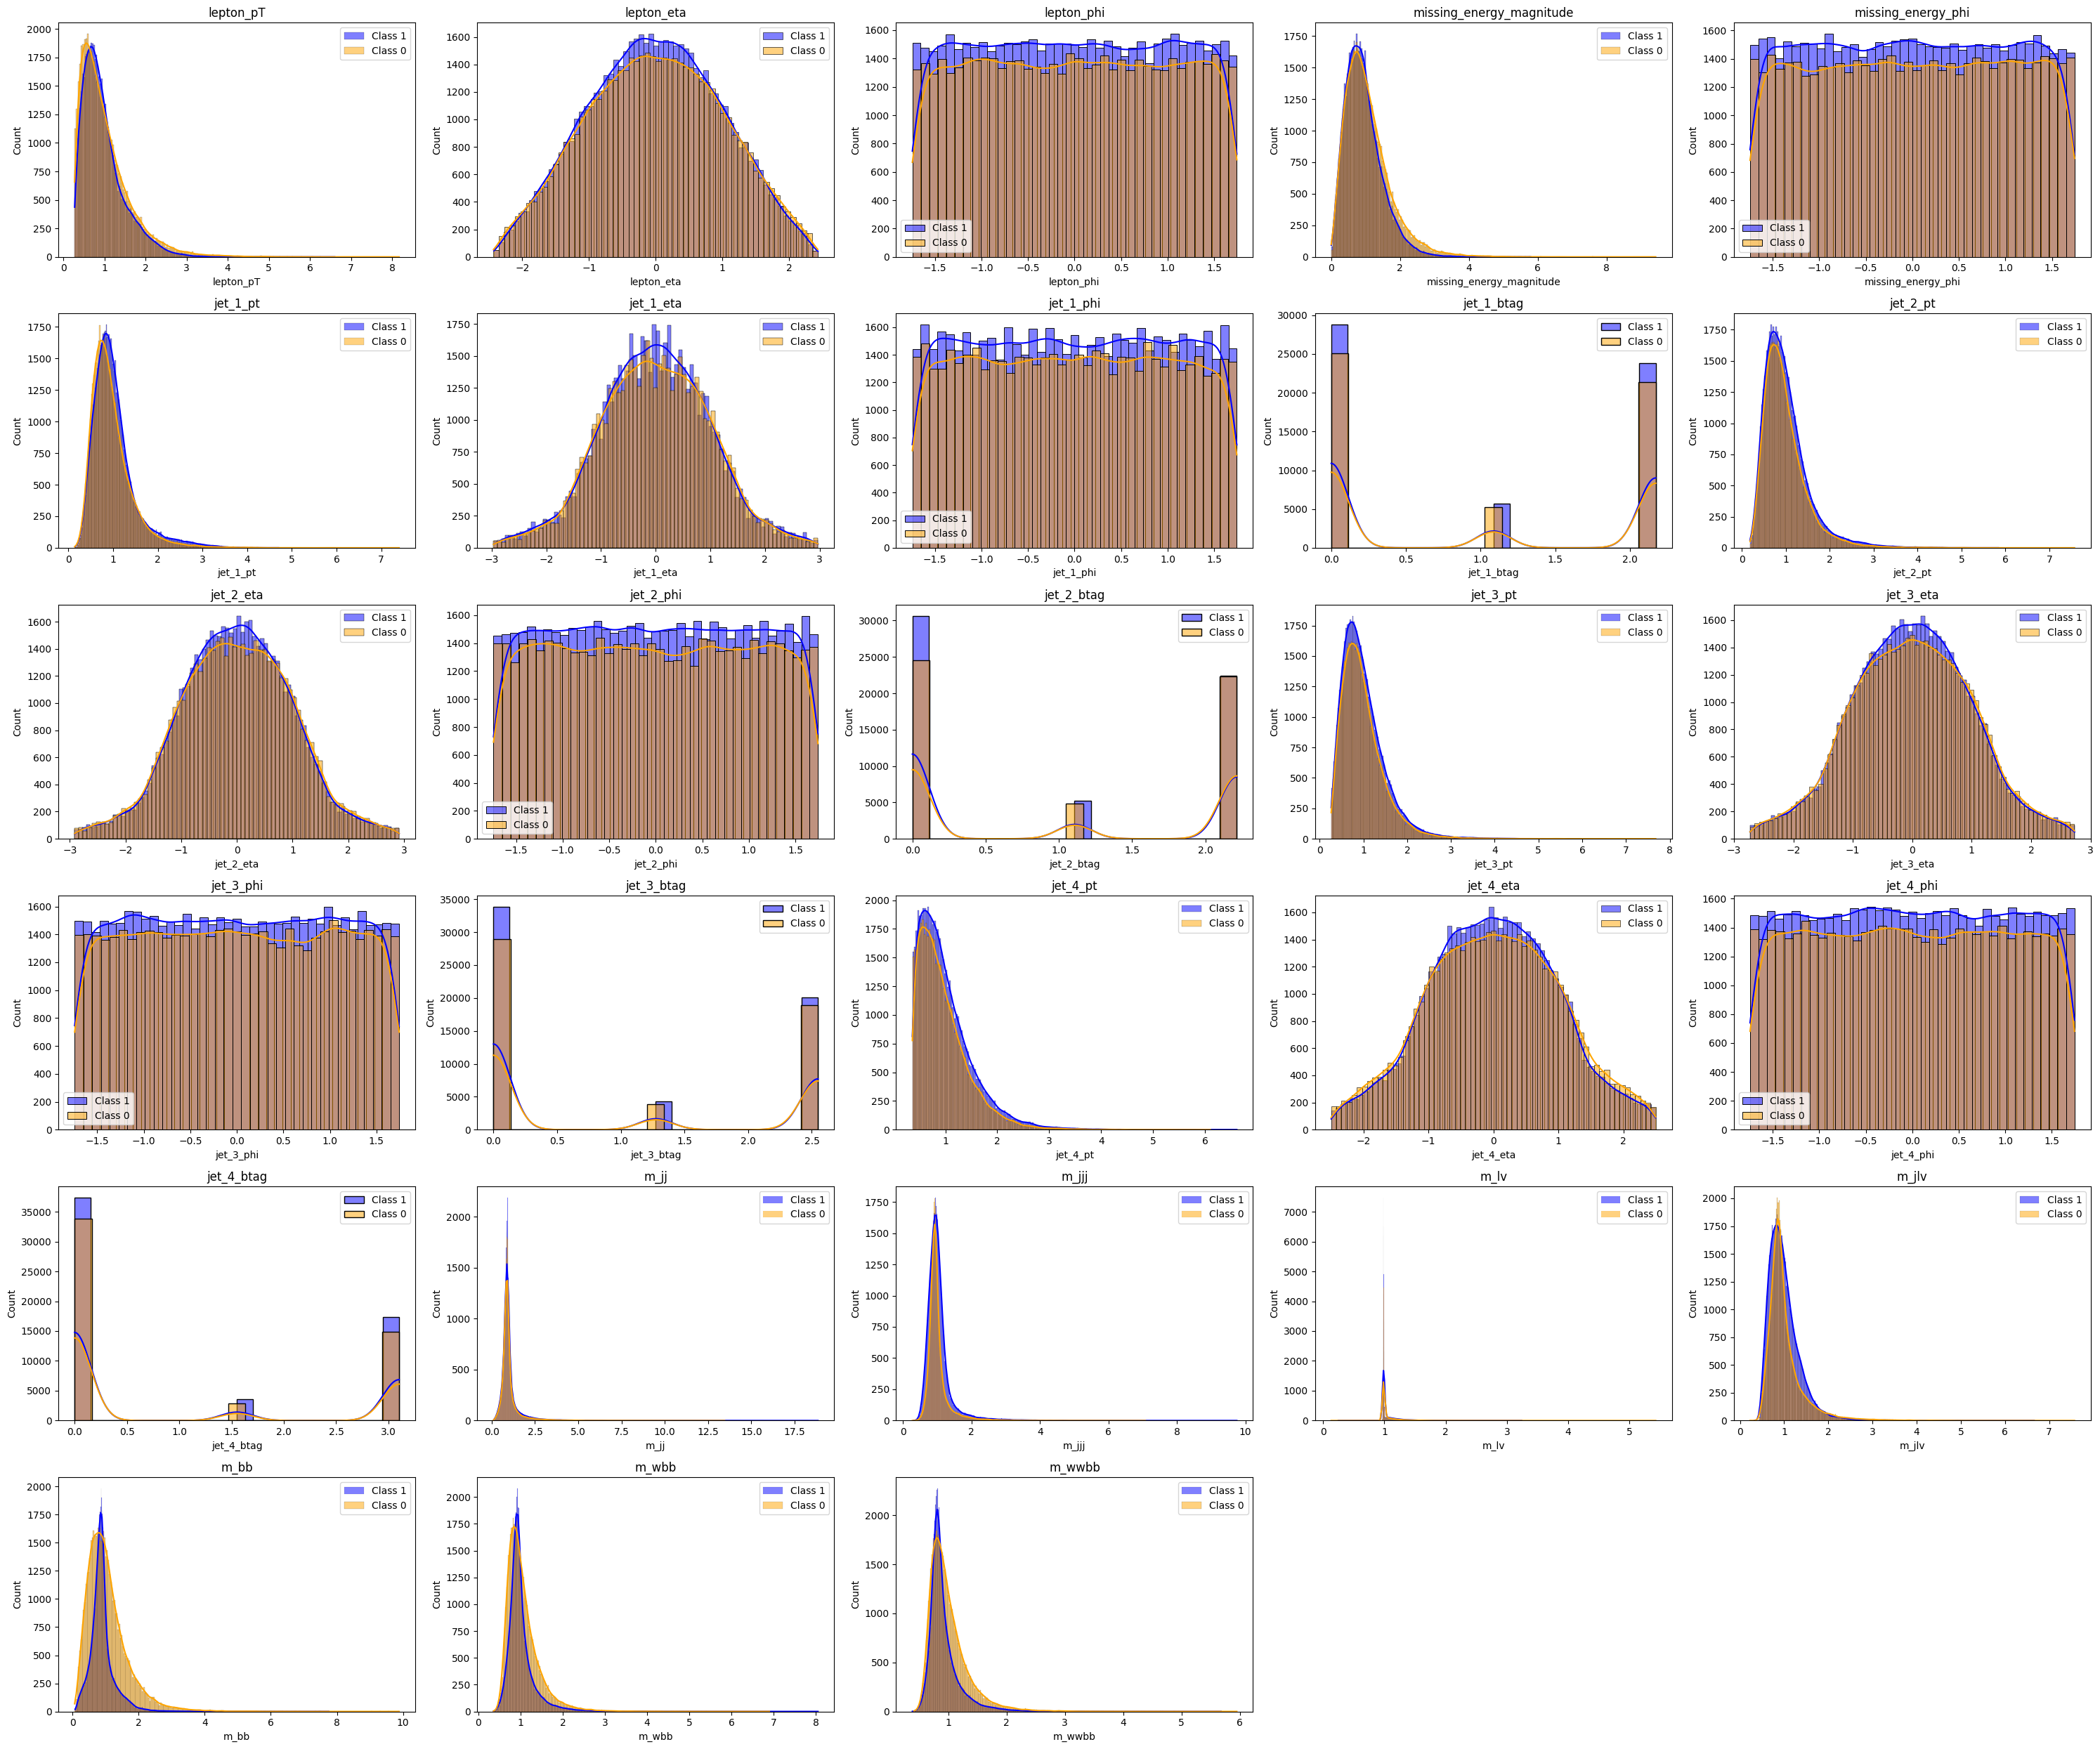

In [19]:
# Plot distributions using seaborn for better visualization
total_columns = len(df.columns) - 1
num_cols = 5
num_rows = (total_columns // num_cols) + 1

plt.figure(figsize=(30, 25))
for i, col in enumerate(df.drop(columns=[y_col]).columns):
    plt.subplot(num_rows, num_cols, i+1)

    # Using seaborn's kdeplot for smoother distribution visualization
    sns.histplot(data=df[df[y_col] == 1][col], color='blue', label='Class 1', fill=True, alpha=0.5, kde=True)
    sns.histplot(data=df[df[y_col] == 0][col], color='orange', label='Class 0', fill=True, alpha=0.5, kde=True)

    plt.title(col, fontsize=12)
    plt.legend()

plt.tight_layout()
plt.show()



The plots tell us that within the features, an instance is classified almost uniformly. By this, it means that there are no "outstanding" features or feature values, that "prefer" one class over another. Thus, we can perform outlier removal techniques since removing the extreme points will not let us lose any categorizable information.

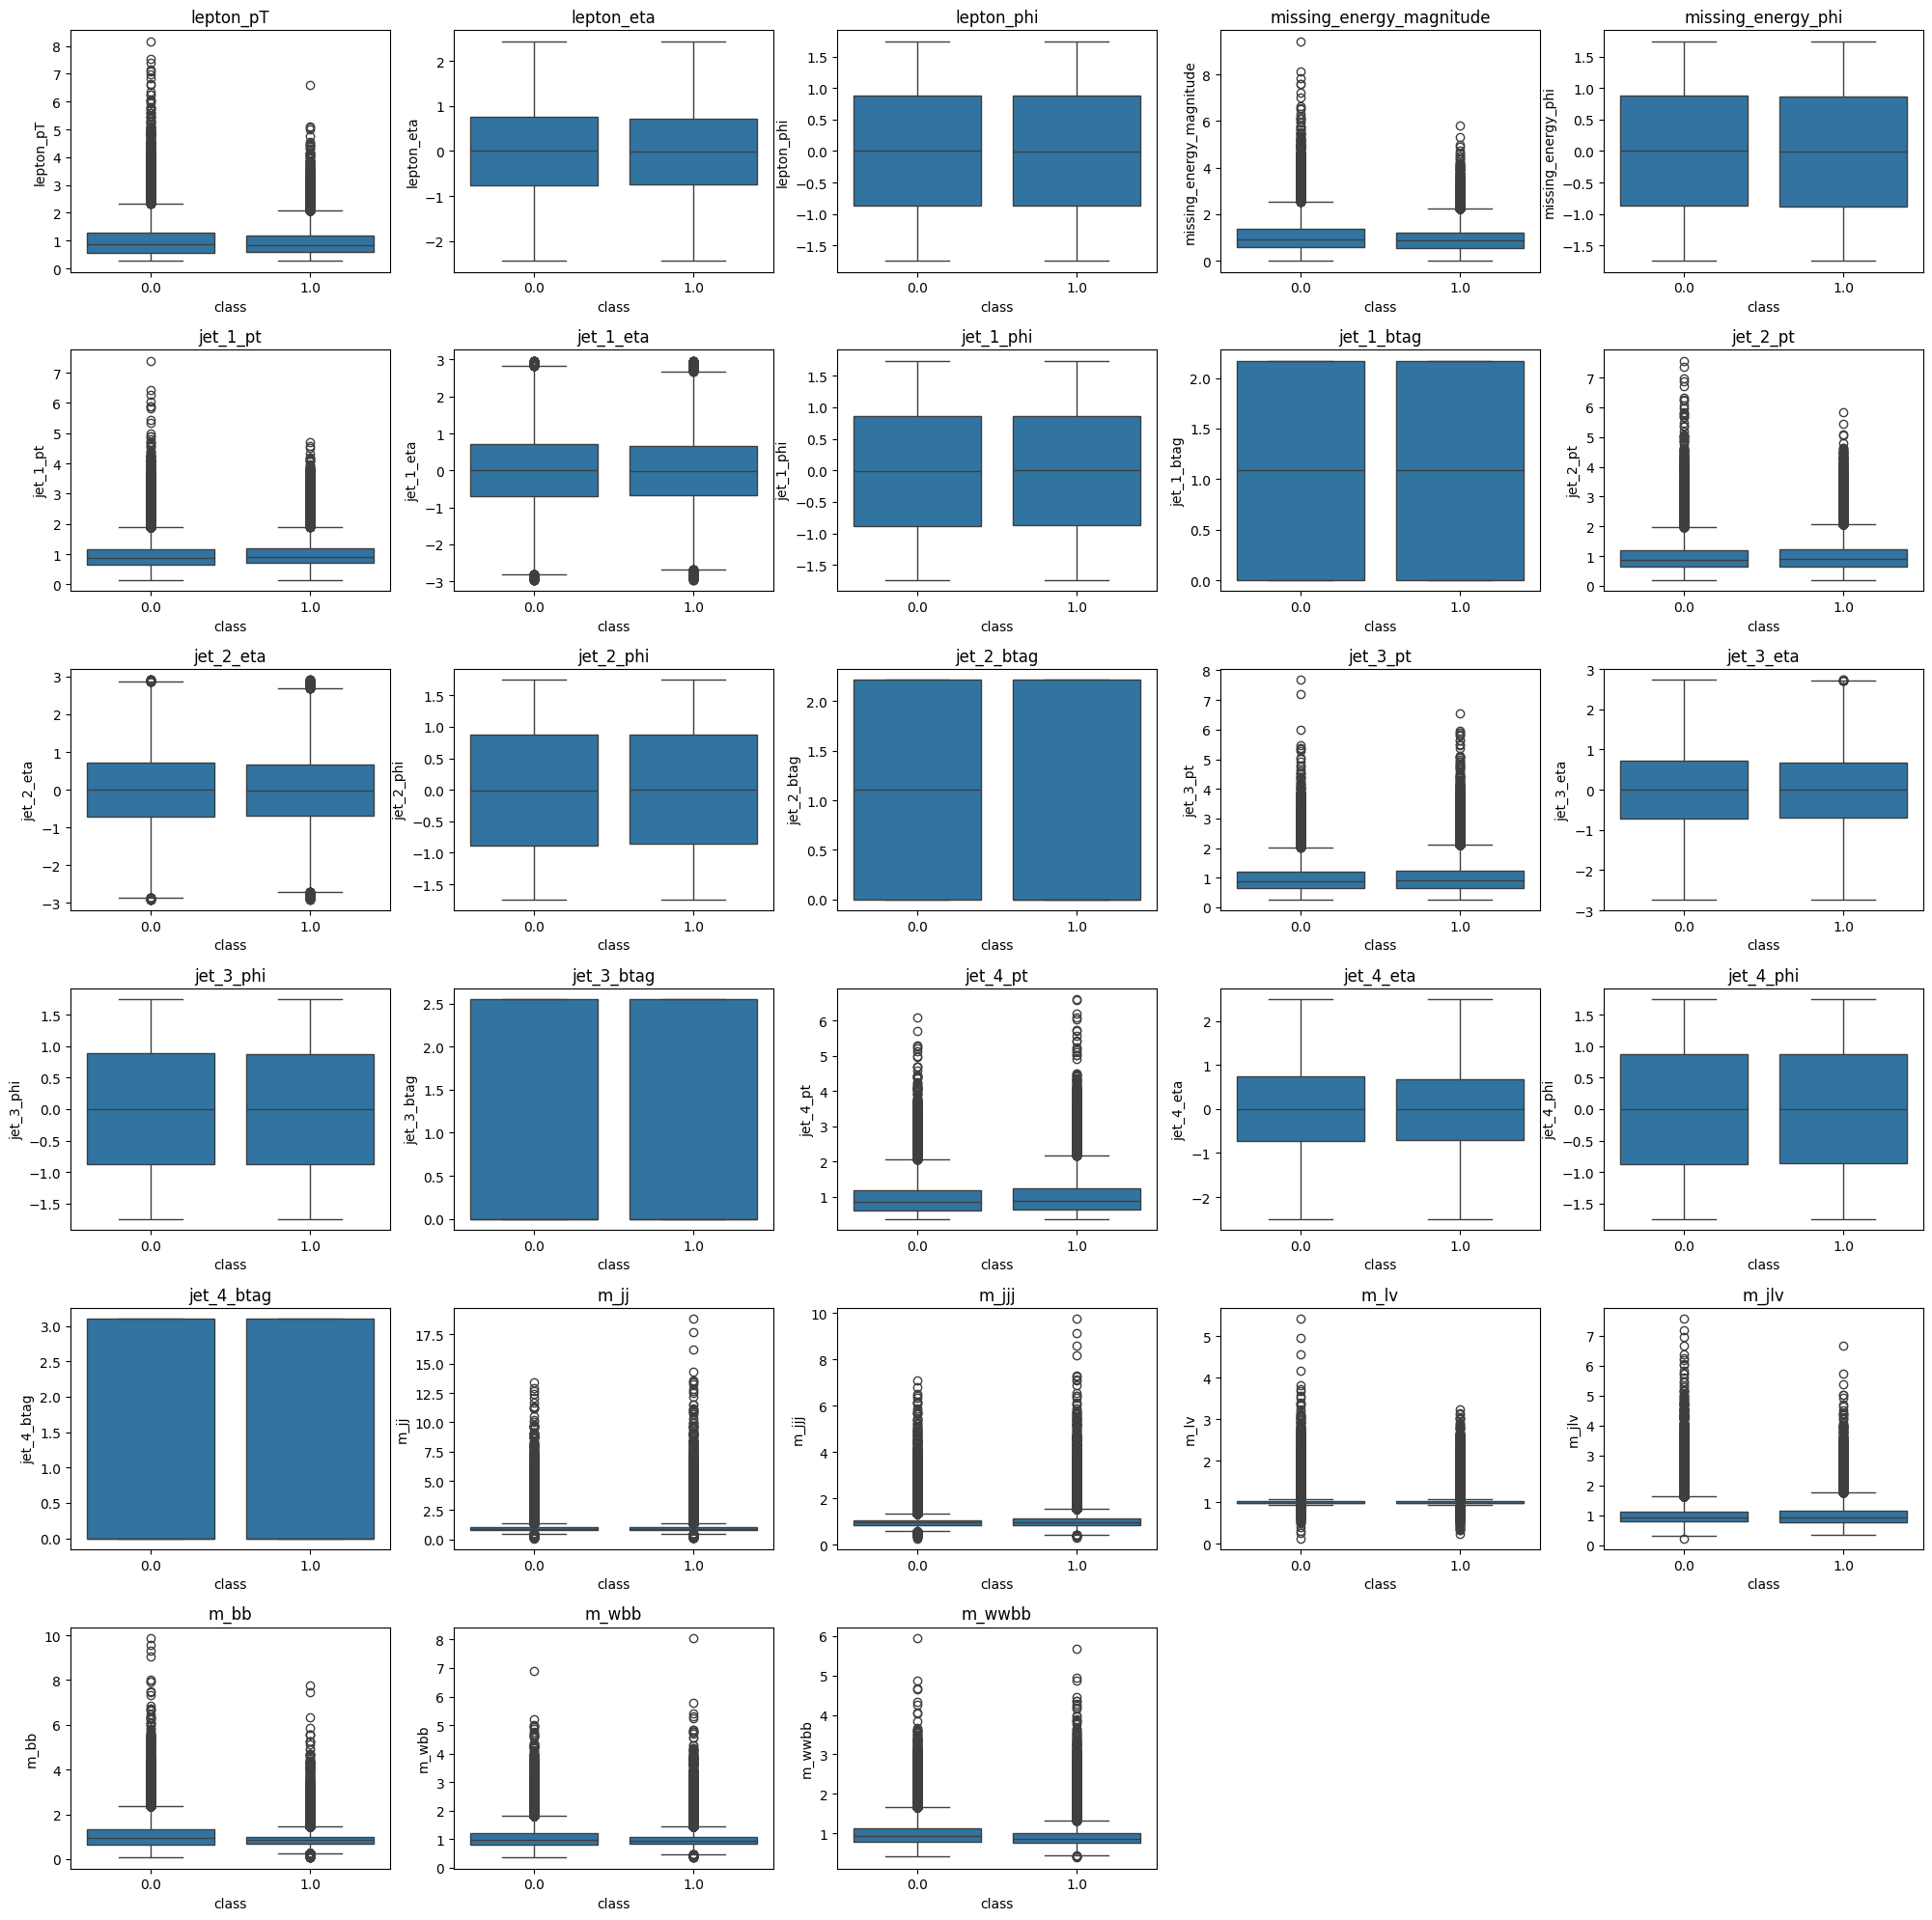

In [20]:
# conditional boxplots of all the features with respect to the classes 0 and 1
plt.figure(figsize=(20, 20))
for i, col in enumerate(df.drop(columns=[y_col]).columns):
    plt.subplot(6, 5, i+1)
    sns.boxplot(x='class', y=col, data=df)
    plt.title(col)
plt.tight_layout()
plt.show()


The box plots of the features conditional on the class show that the features have no charactersitic differences between the classes

We can also see that nearly half the features have values outside the whiskers of the box plots, but the classes are still almost uniformly distributed. Since these points are extreme points, we can remove them and continue.

We can apply outlier removal for the features that have more points around the median and very few outside the whiskers. The technique used will be Z-score. Using this, we find that the number of rows reduce from 110000 to 89387.

\**Z-score*: Z-score is a statistical measurement that describes a value's relationship to the mean of a group of values. Z-score is measured in terms of standard deviations from the mean.

In [21]:
skewed_columns = []
for col in df.columns:
    if 'btag' in col:
        continue
    t = df[col].skew()

    if t > 1.5:
        skewed_columns.append(col)

print(skewed_columns)

['lepton_pT', 'missing_energy_magnitude', 'jet_1_pt', 'jet_2_pt', 'jet_3_pt', 'jet_4_pt', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']


In [22]:
# Function to remove outliers based on z-score
def remove_outliers_zscore(df, column, threshold=3):
    z_scores = (df[column] - df[column].mean()) / df[column].std()
    return df[abs(z_scores) < threshold]

# Apply outlier removal to these columns
for col in skewed_columns:
    df = remove_outliers_zscore(df, col)

df = df.reset_index(drop = True)

df

,class,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_btag,...,jet_4_eta,jet_4_phi,jet_4_btag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,0.0,0.795907,0.521993,1.266055,1.193820,-1.345527,1.050368,0.023740,-0.202843,0.000000,...,1.112191,0.023700,0.000000,1.042175,1.027780,0.985253,0.817024,0.931846,0.893235,0.815815
1,0.0,0.439039,-0.246468,-1.633201,2.165616,-1.280181,1.113852,0.099988,0.030652,0.000000,...,1.272093,1.334957,3.101961,0.847423,1.107451,0.992869,0.645746,0.615797,1.053485,1.169667
2,0.0,0.792429,-0.225041,0.476488,0.216189,-0.653596,0.706933,-1.342777,1.307932,2.173076,...,-1.075636,-1.354807,3.101961,0.812245,0.768737,0.984995,0.809043,0.516027,0.810711,0.770562
3,0.0,2.508689,0.605754,0.057012,1.908093,0.369292,1.448035,1.172407,-1.662516,2.173076,...,1.333722,-1.187779,0.000000,0.483426,0.583755,0.980170,1.504814,0.745402,1.502971,1.080458
4,0.0,0.956040,-0.425679,0.380497,0.382192,1.287647,1.112112,1.256576,0.019010,2.173076,...,-1.447075,0.845525,0.000000,1.010567,1.105782,0.990340,1.734094,1.841294,1.493804,1.189773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89382,1.0,1.367993,-0.729557,0.365515,0.409989,0.940314,1.219658,-0.219856,-1.024430,2.173076,...,-0.553455,1.443720,1.550981,0.958408,1.003733,0.995503,0.599204,0.759077,0.825964,0.745683
89383,1.0,1.326267,-1.027591,-0.629456,1.147094,-0.038268,1.000717,-0.334723,1.111683,2.173076,...,0.176098,-0.395917,0.000000,0.471924,0.605922,0.988520,0.860052,1.002536,1.008905,0.764430
89384,1.0,0.534753,-1.201932,-0.766507,0.721336,-1.586289,0.814297,-0.636743,0.779613,0.000000,...,1.446986,0.315584,0.000000,0.903345,0.907817,0.989411,0.542765,0.531479,0.656743,0.770066
89385,1.0,0.524138,1.794970,0.293383,0.789934,1.561737,0.736888,1.280342,-0.677391,2.173076,...,2.052449,-0.951386,0.000000,0.932308,0.815919,0.987882,0.829535,0.607425,0.616863,0.606310


In [23]:
# splitting the data into features and target
X = df.drop(columns = ['class'])
y = df[['class']]

X.head()

,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_btag,jet_2_pt,...,jet_4_eta,jet_4_phi,jet_4_btag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,0.795907,0.521993,1.266055,1.193820,-1.345527,1.050368,0.023740,-0.202843,0.000000,0.997533,...,1.112191,0.023700,0.000000,1.042175,1.027780,0.985253,0.817024,0.931846,0.893235,0.815815
1,0.439039,-0.246468,-1.633201,2.165616,-1.280181,1.113852,0.099988,0.030652,0.000000,0.726967,...,1.272093,1.334957,3.101961,0.847423,1.107451,0.992869,0.645746,0.615797,1.053485,1.169667
2,0.792429,-0.225041,0.476488,0.216189,-0.653596,0.706933,-1.342777,1.307932,2.173076,0.611513,...,-1.075636,-1.354807,3.101961,0.812245,0.768737,0.984995,0.809043,0.516027,0.810711,0.770562
3,2.508689,0.605754,0.057012,1.908093,0.369292,1.448035,1.172407,-1.662516,2.173076,1.103544,...,1.333722,-1.187779,0.000000,0.483426,0.583755,0.980170,1.504814,0.745402,1.502971,1.080458
4,0.956040,-0.425679,0.380497,0.382192,1.287647,1.112112,1.256576,0.019010,2.173076,1.378392,...,-1.447075,0.845525,0.000000,1.010567,1.105782,0.990340,1.734094,1.841294,1.493804,1.189773


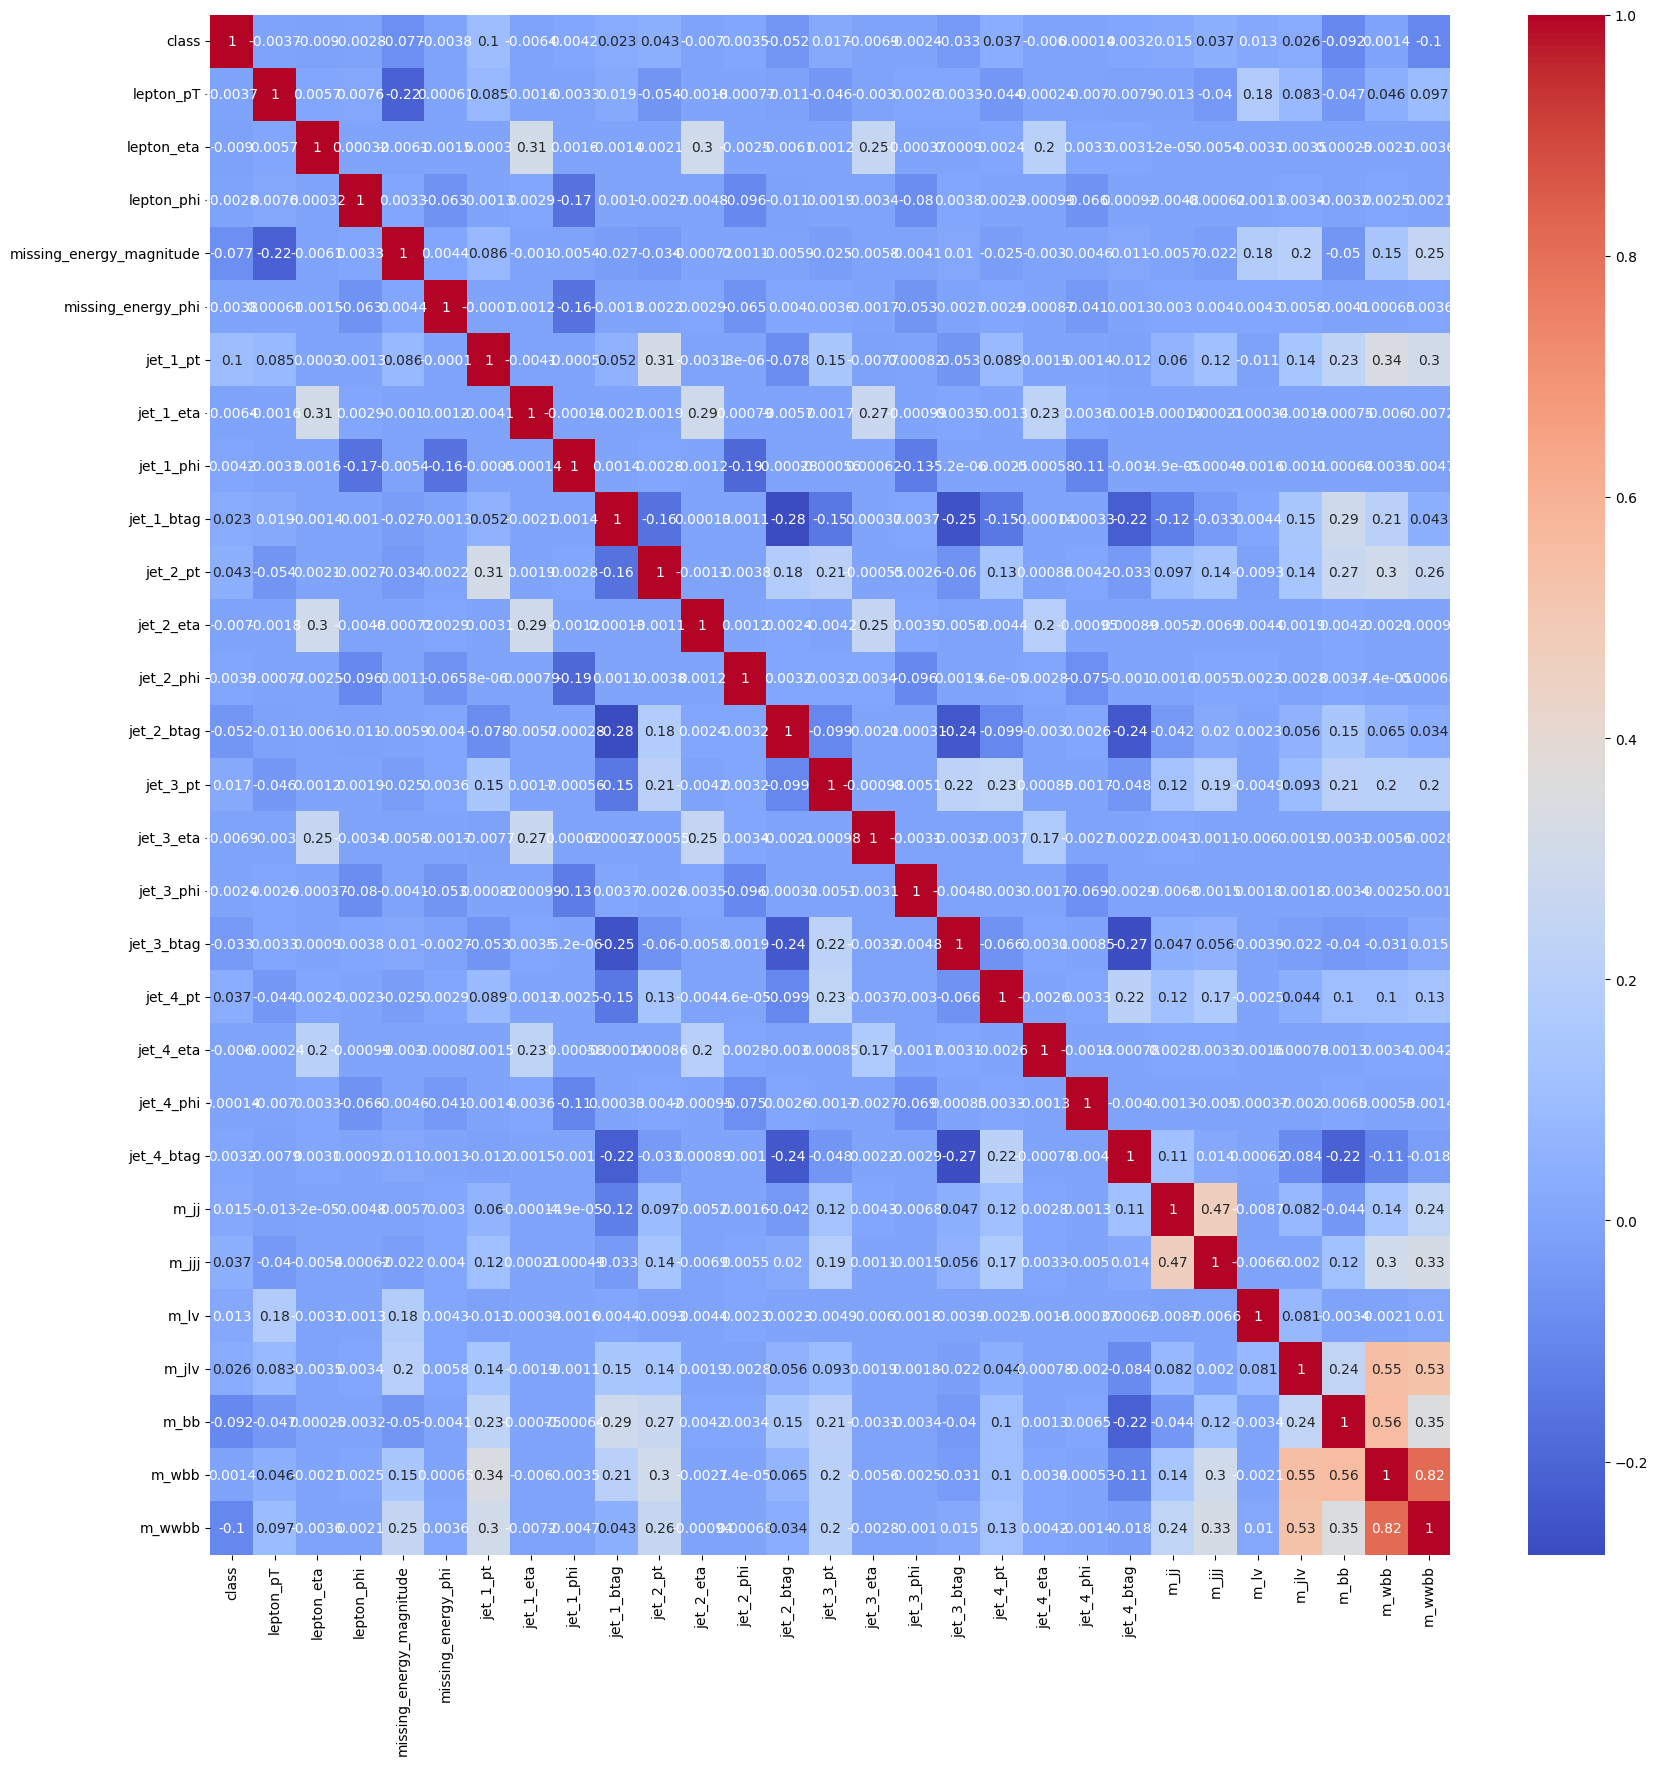

In [24]:
# correlation matrix
corr_matrix = df.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


As evident in the correlation matrix, in general the features are not correlated with each other, but m_wbb and m_wwbb are highly correlated with each other which means we can drop one of them (choosing wbb arbitrarily)

In [25]:
# drop the column m_wbb
X_reduced = pd.DataFrame(X, columns = X.drop(columns=['m_wbb']).columns)

# X_reduced.head()

### Feature Engineering

Feature Engineering for this project involves creating some new features to gain a few insights on how the features are affecting the classification. Here, the features that involve transverse momentum (pT), and the angles (eta, phi) have been added to create one new feature.

Another feature was added that combined 2 invariant masses m_bb and m_wwbb. We will see if these features add some improvement in the correlation or not.


In [26]:
X_feat_eng = X_reduced.copy()

# adding the sum of the transverse momenta of the jets
X_feat_eng['sum_jet_pt'] = X_feat_eng['jet_1_pt'] + X_feat_eng['jet_2_pt'] + X_feat_eng['jet_3_pt'] + X_feat_eng['jet_4_pt']

# adding the sum of the btag values of the jets
X_feat_eng['sum_jet_eta'] = X_feat_eng['jet_1_eta'] + X_feat_eng['jet_2_eta'] + X_feat_eng['jet_3_eta'] + X_feat_eng['jet_4_eta']
X_feat_eng['sum_jet_phi'] = X_feat_eng['jet_1_phi'] + X_feat_eng['jet_2_phi'] + X_feat_eng['jet_3_phi'] + X_feat_eng['jet_4_phi']

X_feat_eng['mass_combination'] = X_feat_eng['m_bb'] + X_feat_eng['m_wwbb']
X_feat_eng['missing_energy_lepton_diff'] = X_feat_eng['missing_energy_magnitude'] - X_feat_eng['lepton_pT']

X_feat_eng.head()

,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_btag,jet_2_pt,...,m_jjj,m_lv,m_jlv,m_bb,m_wwbb,sum_jet_pt,sum_jet_eta,sum_jet_phi,mass_combination,missing_energy_lepton_diff
0,0.795907,0.521993,1.266055,1.193820,-1.345527,1.050368,0.023740,-0.202843,0.000000,0.997533,...,1.027780,0.985253,0.817024,0.931846,0.815815,3.917854,0.868808,-0.244693,1.747661,0.397913
1,0.439039,-0.246468,-1.633201,2.165616,-1.280181,1.113852,0.099988,0.030652,0.000000,0.726967,...,1.107451,0.992869,0.645746,0.615797,1.169667,3.541985,0.550097,1.029781,1.785464,1.726577
2,0.792429,-0.225041,0.476488,0.216189,-0.653596,0.706933,-1.342777,1.307932,2.173076,0.611513,...,0.768737,0.984995,0.809043,0.516027,0.770562,3.019509,-5.414889,-1.475345,1.286590,-0.576241
3,2.508689,0.605754,0.057012,1.908093,0.369292,1.448035,1.172407,-1.662516,2.173076,1.103544,...,0.583755,0.980170,1.504814,0.745402,1.080458,3.434097,4.144453,-3.058275,1.825860,-0.600596
4,0.956040,-0.425679,0.380497,0.382192,1.287647,1.112112,1.256576,0.019010,2.173076,1.378392,...,1.105782,0.990340,1.734094,1.841294,1.189773,3.664320,1.738982,-1.922048,3.031067,-0.573847


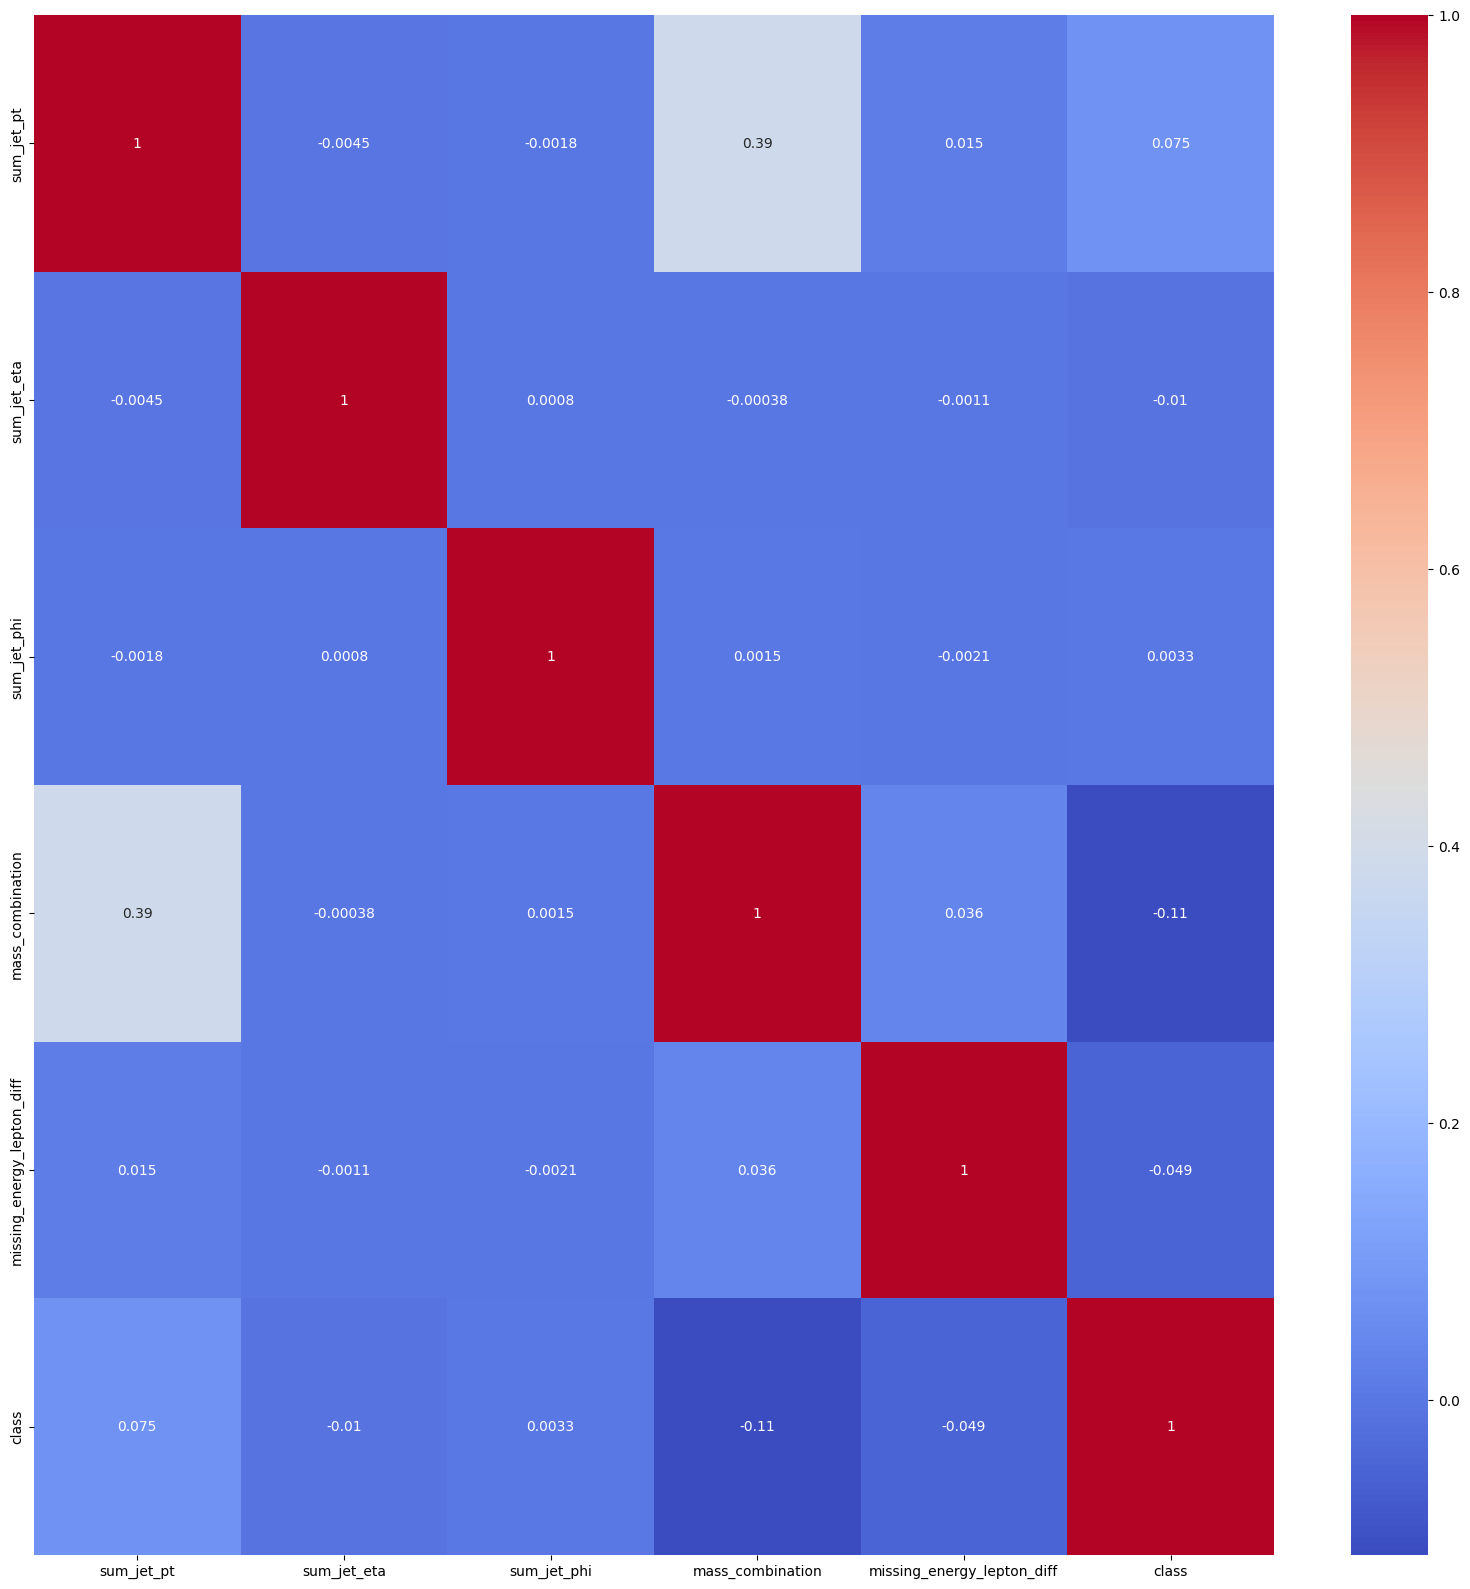

In [27]:
# see correlation of new features with the target
# create a temporary df to store only the new features and the target
temp_df = X_feat_eng.iloc[:, 27:33]
temp_df['class'] = y

corr_matrix = temp_df.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [28]:
# the correlation seems to improve a little for sum_jet_pt and mass_combination
# thus we can keep these features and drop the rest

X_feat_eng = X_feat_eng.drop(columns=['sum_jet_eta', 'sum_jet_phi', 'missing_energy_lepton_diff'])

X_feat_eng.head()

,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_btag,jet_2_pt,...,jet_4_phi,jet_4_btag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wwbb,sum_jet_pt,mass_combination
0,0.795907,0.521993,1.266055,1.193820,-1.345527,1.050368,0.023740,-0.202843,0.000000,0.997533,...,0.023700,0.000000,1.042175,1.027780,0.985253,0.817024,0.931846,0.815815,3.917854,1.747661
1,0.439039,-0.246468,-1.633201,2.165616,-1.280181,1.113852,0.099988,0.030652,0.000000,0.726967,...,1.334957,3.101961,0.847423,1.107451,0.992869,0.645746,0.615797,1.169667,3.541985,1.785464
2,0.792429,-0.225041,0.476488,0.216189,-0.653596,0.706933,-1.342777,1.307932,2.173076,0.611513,...,-1.354807,3.101961,0.812245,0.768737,0.984995,0.809043,0.516027,0.770562,3.019509,1.286590
3,2.508689,0.605754,0.057012,1.908093,0.369292,1.448035,1.172407,-1.662516,2.173076,1.103544,...,-1.187779,0.000000,0.483426,0.583755,0.980170,1.504814,0.745402,1.080458,3.434097,1.825860
4,0.956040,-0.425679,0.380497,0.382192,1.287647,1.112112,1.256576,0.019010,2.173076,1.378392,...,0.845525,0.000000,1.010567,1.105782,0.990340,1.734094,1.841294,1.189773,3.664320,3.031067


In [29]:
# Apply log-transformation to the feautres having either "pt" or "m_" in their names
log_transform_columns = [col for col in X_feat_eng.columns if (('pt' in col and 'lepton' not in col) or ('m_' in col and 'sum_' not in col))]

#calculate the skewness of the columns
skewness = X_feat_eng[log_transform_columns].apply(lambda x: x.skew())

X_log_transformed = X_feat_eng.copy()

X_log_transformed[log_transform_columns] = np.log1p(X_feat_eng[log_transform_columns])

#calculate the skewness of the columns after log transformation
skewness_after = X_log_transformed[log_transform_columns].apply(lambda x: x.skew())

print("Skewness before log transformation: \n", skewness)
print("\nSkewness after log transformation: \n", skewness_after)

Skewness before log transformation: 
 jet_1_pt      0.881885
jet_2_pt      0.832616
jet_3_pt      0.825316
jet_4_pt      0.981074
m_jj          1.935039
m_jjj         0.645414
m_lv          2.455376
m_jlv         1.028096
m_bb          0.783329
m_wwbb        0.734528
sum_jet_pt    0.774100
dtype: float64

Skewness after log transformation: 
 jet_1_pt      0.358661
jet_2_pt      0.343230
jet_3_pt      0.353184
jet_4_pt      0.543047
m_jj          0.964680
m_jjj         0.279852
m_lv          2.311788
m_jlv         0.643812
m_bb          0.160005
m_wwbb        0.480200
sum_jet_pt    0.221756
dtype: float64


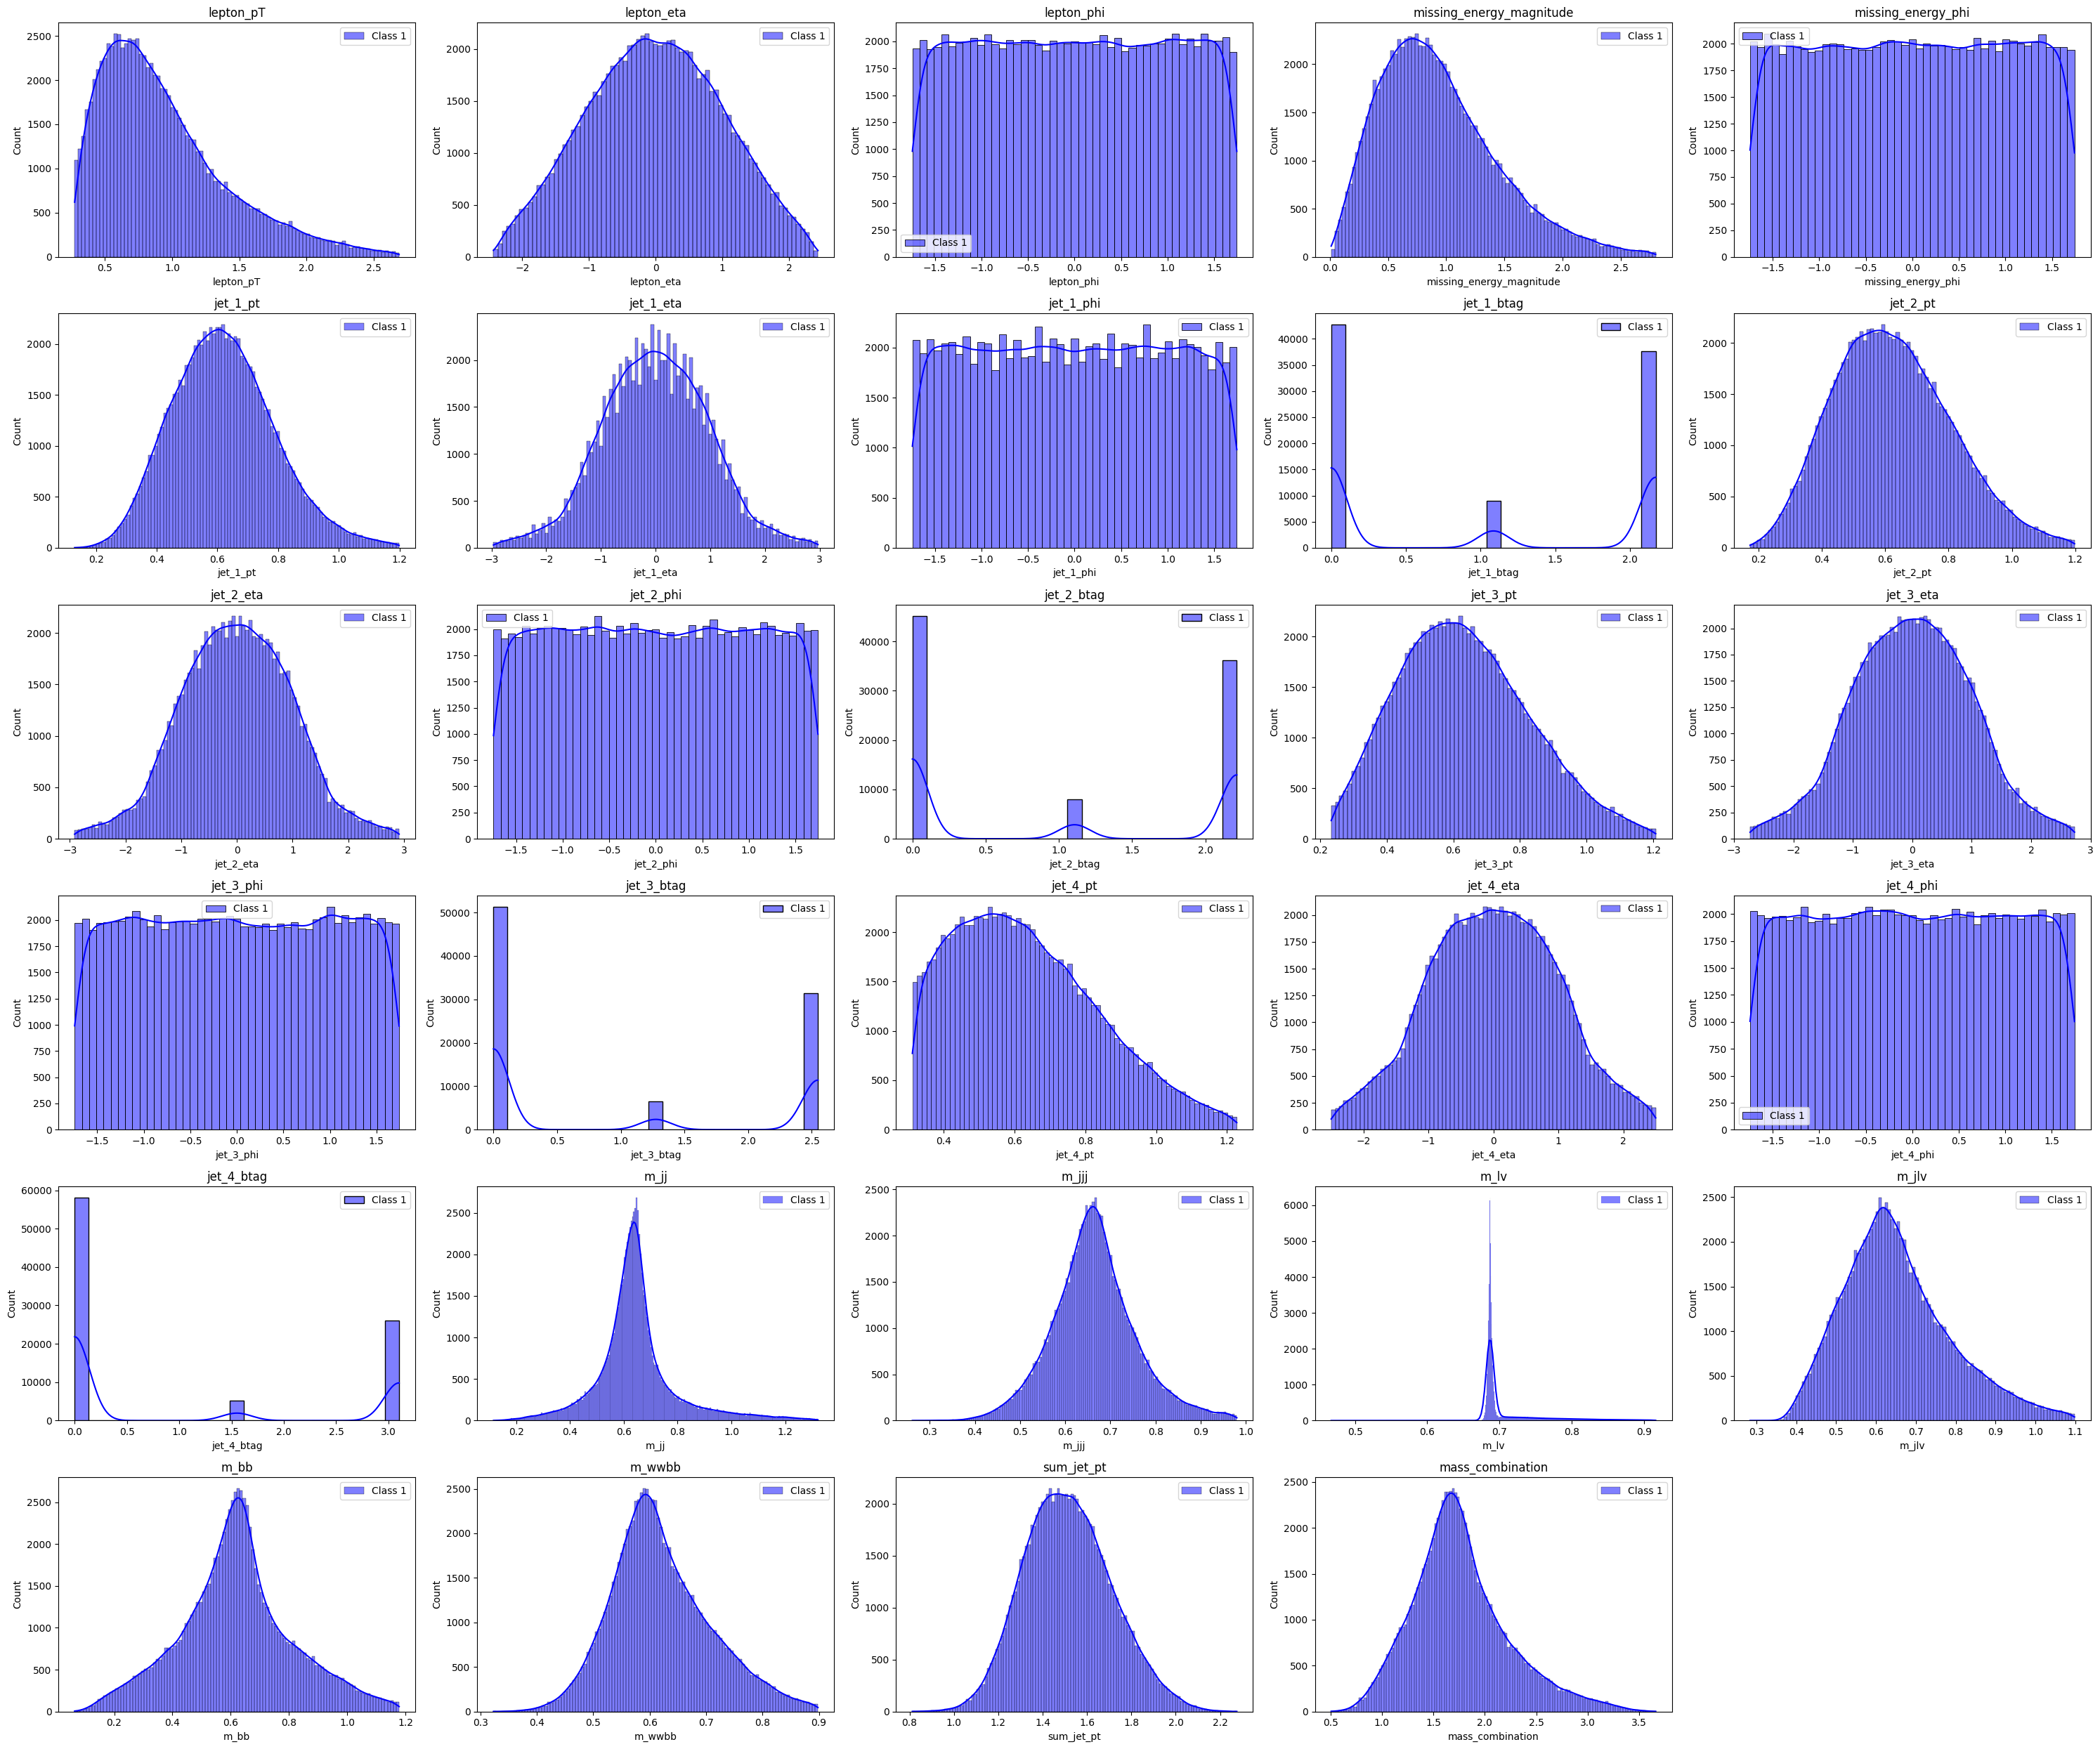

In [30]:
# visualize the distributions of the features after the changes

plt.figure(figsize=(30, 25))
for i, col in enumerate(X_log_transformed.columns):
    plt.subplot(num_rows, num_cols, i+1)

    # Using seaborn's kdeplot for smoother distribution visualization
    sns.histplot(data=X_log_transformed[col], color='blue', label='Class 1', fill=True, alpha=0.5, kde=True)

    plt.title(col, fontsize=12)
    plt.legend()

plt.tight_layout()
plt.show()

### Data Normalization


We will normalize the data such that mean is 0 and standard deviation is 1

In [31]:
for col in X_log_transformed.columns:
    X_log_transformed[col] = (X_log_transformed[col] - X_log_transformed[col].mean()) / X_log_transformed[col].std()

X_log_transformed.describe()

,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_btag,jet_2_pt,...,jet_4_phi,jet_4_btag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wwbb,sum_jet_pt,mass_combination
count,8.938700e+04,8.938700e+04,8.938700e+04,8.938700e+04,89387.000000,8.938700e+04,8.938700e+04,8.938700e+04,8.938700e+04,8.938700e+04,...,8.938700e+04,8.938700e+04,8.938700e+04,8.938700e+04,8.938700e+04,8.938700e+04,8.938700e+04,8.938700e+04,8.938700e+04,8.938700e+04
mean,-1.317954e-16,-1.399035e-17,-1.764692e-17,-1.310005e-16,0.000000,1.196811e-15,1.399035e-17,-1.025429e-17,-4.578659e-17,7.631099e-17,...,4.403780e-17,-5.373565e-17,-2.090603e-17,1.211437e-16,-5.567522e-16,-1.561196e-16,2.162145e-17,-8.025372e-16,9.437125e-16,-1.081072e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.413199e+00,-2.402162e+00,-1.734294e+00,-1.815803e+00,-1.732983,-2.914338e+00,-3.041100e+00,-1.725657e+00,-9.971927e-01,-2.429149e+00,...,-1.732471e+00,-7.115462e-01,-3.537237e+00,-4.331256e+00,-5.245680e+00,-2.736146e+00,-2.847793e+00,-3.362685e+00,-3.559491e+00,-2.687754e+00
25%,-7.523984e-01,-7.263369e-01,-8.675218e-01,-7.419861e-01,-0.865943,-7.074260e-01,-6.753670e-01,-8.663977e-01,-9.971927e-01,-7.320396e-01,...,-8.625048e-01,-7.115462e-01,-4.516627e-01,-6.119158e-01,-4.649302e-01,-7.030176e-01,-5.957288e-01,-6.730569e-01,-7.122131e-01,-6.520516e-01
50%,-2.236805e-01,-2.202859e-03,-6.450224e-04,-1.540092e-01,-0.000467,-5.225270e-02,-4.229908e-03,-2.724326e-03,5.922220e-02,-7.022002e-02,...,-5.767671e-03,-7.115462e-01,-7.846830e-02,-3.512834e-02,-4.235759e-01,-1.329554e-01,-1.860084e-02,-1.356821e-01,-4.866154e-02,-1.185598e-01
75%,5.136500e-01,7.286807e-01,8.705380e-01,5.761204e-01,0.868055,6.330419e-01,6.750298e-01,8.621519e-01,1.115637e+00,6.626257e-01,...,8.654030e-01,1.505088e+00,2.807944e-01,5.577360e-01,-2.355593e-01,5.698777e-01,5.452281e-01,5.991380e-01,6.624880e-01,5.251659e-01
max,3.712374e+00,2.417041e+00,1.729591e+00,3.653865e+00,1.729749,3.421509e+00,3.041778e+00,1.739059e+00,1.115637e+00,3.082135e+00,...,1.730958e+00,1.505088e+00,4.511184e+00,3.392136e+00,4.560270e+00,3.293417e+00,2.856607e+00,3.129600e+00,3.848616e+00,4.053464e+00


### Feature Selection

We will use the SelectKBest as our selection algorithm

\**SelectKBest*: It is a filter-based feature selection method, which relies on statistical measures to score and rank the features. It uses statistical tests like chi-squared test, ANOVA F-test, or mutual information score. Then, it selects the K features with the highest scores to be included in the final feature subset.


In [32]:
# using f_classif as the scoring function
selector = SelectKBest(f_classif, k=20)
X_new = selector.fit_transform(X_log_transformed, y)

X_new = pd.DataFrame(X_new, columns=X_log_transformed.columns[selector.get_support()])

# get the selected features
selected_features = X_log_transformed.columns[selector.get_support()]
selected_features

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Index(['lepton_eta', 'missing_energy_magnitude', 'jet_1_pt', 'jet_1_eta',
       'jet_1_btag', 'jet_2_pt', 'jet_2_eta', 'jet_2_btag', 'jet_3_pt',
       'jet_3_eta', 'jet_3_btag', 'jet_4_pt', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv',
       'm_bb', 'm_wwbb', 'sum_jet_pt', 'mass_combination'],
      dtype='object')

# Model Training

In [33]:
!pip install scikit-optimize


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.2 MB/s eta 0:00:00


In [34]:
import time
from sklearn.base import clone
from sklearn.model_selection import cross_validate

from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.base import BaseEstimator, ClassifierMixin

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import warnings
warnings.filterwarnings("ignore")

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

Determining the Scoring metrics on which the results will be found.

Following is a dictionary that maps the metric to the corresponding library function


In [35]:
SCORING_METRICS = {
    'accuracy': accuracy_score,
    'f1': f1_score,
    'precision': precision_score,
    'recall': recall_score,
    'roc_auc': roc_auc_score
}

Splitting the data into train and test sets

In [36]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

print("Train shape: ", X_train.shape)
print("Test shape: ", X_test.shape)

Train shape:  (71509, 20)
Test shape:  (17878, 20)


Defining 3 functions:
1. run_cross_validation(): It uses the built-in function cross_validate instead of cross_val_score because we can pass a list of keys that represent the scoring metrics (instead of just 1 metric)

2. run_grid_search(): Performs grid search on the parameter_grid and the model that is passed to it as a paramemter. We clone the model to _model, since there may be scenarios where the model gets updated during the execution which may affect the outcome.

3. run_bayesian_optimzation_search(): a similar function that performs bayesian optimization on the search_space provided and the model passed.

In [37]:
def run_cross_validation(model, X_train, y_train):

    _model = clone(model)
    cv_results = cross_validate(_model, X_train, y_train, cv=5, scoring = list(SCORING_METRICS.keys()))
    avg_cv_results = {}
    for key in cv_results:
        avg_cv_results[f'avg_{key.replace("test", "val")}'] = np.mean(cv_results[key])

    return avg_cv_results

def run_grid_search(model, X_train, y_train, params, scoring):
    _model = clone(model)

    grid_search_model = GridSearchCV(estimator=_model, param_grid=params, cv=5, scoring=list(SCORING_METRICS.keys()), n_jobs=-1, refit = 'accuracy')
    grid_search_model.fit(X_train, y_train)

    grid_search_results = []

    i = 0
    for params in grid_search_model.cv_results_['params']:
        data = {}
        for param in params:
            data[param] = params[param]
        for key in SCORING_METRICS:
            data[f'mean_val_{key}'] = grid_search_model.cv_results_[f'mean_test_{key}'][i]

        data[f'mean_fit_time'] = grid_search_model.cv_results_['mean_fit_time'][i]
        data[f'mean_score_time'] = grid_search_model.cv_results_['mean_score_time'][i]
        i += 1

        grid_search_results.append(data)

    return grid_search_model, grid_search_results

def run_bayesian_optimzation_search(model, X_train, y_train, params, scoring):
    _model = clone(model)

    bayes_search_model = BayesSearchCV(estimator=_model, search_spaces=params, cv=5, scoring=list(SCORING_METRICS.keys()), n_iter=10, n_jobs=-1, refit = 'accuracy')
    bayes_search_model.fit(X_train, y_train)

    bayes_search_results = []

    i = 0
    for params in bayes_search_model.cv_results_['params']:
        data = {}
        for param in params:
            data[param] = params[param]
        for key in SCORING_METRICS:
            data[f'mean_val_{key}'] = bayes_search_model.cv_results_[f'mean_test_{key}'][i]

        data[f'mean_fit_time'] = bayes_search_model.cv_results_['mean_fit_time'][i]
        data[f'mean_score_time'] = bayes_search_model.cv_results_['mean_score_time'][i]
        i += 1

        bayes_search_results.append(data)

    return bayes_search_model, bayes_search_results


def evaluate_model_predictions(y_true, y_pred):
    test_results = {}
    for key in SCORING_METRICS:
        test_results[key] = SCORING_METRICS[key](y_true, y_pred)
    return test_results

#### Linear SVM

Using the LinearSVC function to perform SVM classification with linear kernel and using cross_validation to evaluate the performance


In [38]:
linear_svm = LinearSVC(random_state = RANDOM_STATE)

cv_results = run_cross_validation(linear_svm, X_train, y_train)
print("Cross Validation Evaluation:")
display(pd.DataFrame([cv_results]))

print("Avg Validation Score:", cv_results['avg_val_accuracy'])

Cross Validation Evaluation:


,avg_fit_time,avg_score_time,avg_val_accuracy,avg_val_f1,avg_val_precision,avg_val_recall,avg_val_roc_auc
0,0.807773,0.193984,0.632662,0.694825,0.631208,0.772713,0.689946


Avg Validation Score: 0.6326616272231839


### Scalability and Efficiency

LinearSVC is a relatively fast functionality. However if we use SVC with kernel='linear', it takes a lot of time. This is why there are methods such as Stochastic Gradient Descent, or Mini-batch learning that train the models very quickly. For comparison, we shall see the difference in training times for SGD and LinearSVC.

In [39]:
# perform SGD with hinge loss

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss='hinge', random_state=RANDOM_STATE)

cv_results = run_cross_validation(sgd_clf, X_train, y_train)
print("Cross Validation Evaluation:")
display(pd.DataFrame([cv_results]))

print("Avg Validation Score:", cv_results['avg_val_accuracy'])

Cross Validation Evaluation:


,avg_fit_time,avg_score_time,avg_val_accuracy,avg_val_f1,avg_val_precision,avg_val_recall,avg_val_roc_auc
0,1.274936,0.205667,0.628173,0.691768,0.627427,0.77168,0.681264


Avg Validation Score: 0.6281726770786247


### Other Kernels

Due to less computation power and high training time taken by other kernels when used with SVC, only a small number of training examples had to be used (5% of even the 1% ~ 3k-4K data points).

In [40]:
X_train_small = X_train.sample(frac=0.03, random_state=RANDOM_STATE)
y_train_small = y_train.loc[X_train_small.index]

#### Polynomial Kernel SVM

The polynomial kernel maps input data points to a higher-dimensional feature space using polynomial functions. In this new space, a hyperplane can separate the data points into classes, which corresponds to a non-linear decision boundary in the original input space. Thus, a polynomial kernel is used to model non-linear relationships between input features.

In [41]:
poly_svc = SVC(random_state = RANDOM_STATE, kernel = 'poly')

param_grid = {
    'degree': [2, 3, 4],
}

grid_search_model, cv_results = run_grid_search(poly_svc, X_train_small, y_train_small, params = param_grid, scoring = 'accuracy')

print("Grid Search Evaluation:")
display(pd.DataFrame(cv_results))

print("Best Model:")
display(grid_search_model.best_estimator_)

print("Best Validation Score:")
print(grid_search_model.best_score_)

cv_results_poly = cv_results

Grid Search Evaluation:


,degree,mean_val_accuracy,mean_val_f1,mean_val_precision,mean_val_recall,mean_val_roc_auc,mean_fit_time,mean_score_time
0,2,0.627972,0.709691,0.626434,0.818828,0.675300,0.552900,0.353211
1,3,0.606061,0.701123,0.605987,0.832179,0.624225,0.939154,0.443580
2,4,0.589277,0.699401,0.589444,0.859917,0.632292,0.757986,0.331392


Best Model:


SVC(degree=2, kernel='poly', random_state=42)

Best Validation Score:
0.627972027972028


In [42]:
poly_svc = SVC(random_state = RANDOM_STATE, kernel = 'poly', degree = 2)

param_grid = {
    'C': [1, 10, 100, 1000]
}

grid_search_model, cv_results = run_grid_search(poly_svc, X_train_small, y_train_small, params = param_grid, scoring = 'accuracy')

print("Grid Search Evaluation:")
display(pd.DataFrame(cv_results))

print("Best Model:")
display(grid_search_model.best_estimator_)

print("Best Validation Score:")
print(grid_search_model.best_score_)

cv_results_poly_c = cv_results

Grid Search Evaluation:


,C,mean_val_accuracy,mean_val_f1,mean_val_precision,mean_val_recall,mean_val_roc_auc,mean_fit_time,mean_score_time
0,1,0.627972,0.709691,0.626434,0.818828,0.675300,0.438166,0.263205
1,10,0.626573,0.687089,0.643020,0.738297,0.664717,0.819299,0.217622
2,100,0.621911,0.678522,0.643441,0.718139,0.661431,7.615464,0.282408
3,1000,0.624709,0.678319,0.647930,0.712264,0.662885,58.379114,0.175603


Best Model:


SVC(C=1, degree=2, kernel='poly', random_state=42)

Best Validation Score:
0.627972027972028


#### RBF Kernel SVM

The RBF (Radial Basis Function) kernel function calculates the similarity between two points, $X_{1}$ and $X_{2}$, by computing the squared Euclidean distance between them. The kernel's value decreases with distance. It is used to deal with overlapping data. It behaves like a weighted nearest neighbor model, where the closest observations have the most influence on how a new observation is classified.

In [43]:
rbf_svc = SVC(random_state = RANDOM_STATE, kernel = 'rbf')

param_grid = {
    'gamma': [0.01, 0.1, 1, 10],
}

grid_search_model, cv_results = run_grid_search(rbf_svc, X_train_small, y_train_small, params = param_grid, scoring = 'accuracy')

print("Grid Search Evaluation:")
display(pd.DataFrame(cv_results))

print("Best Model:")
display(grid_search_model.best_estimator_)

print("Best Validation Score:")
print(grid_search_model.best_score_)

cv_results_rbf_gamma = cv_results

Grid Search Evaluation:


,gamma,mean_val_accuracy,mean_val_f1,mean_val_precision,mean_val_recall,mean_val_roc_auc,mean_fit_time,mean_score_time
0,0.01,0.638695,0.721867,0.630814,0.843961,0.692916,0.236822,0.276235
1,0.10,0.661538,0.717848,0.668485,0.775159,0.715824,0.274249,0.277321
2,1.00,0.555711,0.714413,0.555711,1.000000,0.600260,0.403181,0.415913
3,10.00,0.555711,0.714413,0.555711,1.000000,0.509189,0.691906,0.596321


Best Model:


SVC(gamma=0.1, random_state=42)

Best Validation Score:
0.6615384615384616


In [44]:
# seeing the effect of C on rbf kernel by keeping gamma fixed to the best value obtain in the run before.

rbf_svc = SVC(random_state = RANDOM_STATE, kernel = 'rbf', gamma = 0.1)

param_grid = {
    'C': [0.1, 1, 10, 100],
}

grid_search_model, cv_results = run_grid_search(rbf_svc, X_train_small, y_train_small, params = param_grid, scoring = 'accuracy')

print("Grid Search Evaluation:")
display(pd.DataFrame(cv_results))

print("Best Model:")
display(grid_search_model.best_estimator_)

print("Best Validation Score:")
print(grid_search_model.best_score_)

cv_results_rbf_c = cv_results

Grid Search Evaluation:


,C,mean_val_accuracy,mean_val_f1,mean_val_precision,mean_val_recall,mean_val_roc_auc,mean_fit_time,mean_score_time
0,0.1,0.561305,0.715969,0.559179,0.994972,0.712927,0.533981,0.715266
1,1.0,0.661538,0.717848,0.668485,0.775159,0.715824,0.521574,0.649451
2,10.0,0.637762,0.682676,0.665477,0.701375,0.681902,0.436870,0.344971
3,100.0,0.629837,0.675261,0.658920,0.692982,0.675402,0.431163,0.341074


Best Model:


SVC(C=1, gamma=0.1, random_state=42)

Best Validation Score:
0.6615384615384616


#### Custom Kernel SVM

So far, the RBF kernel outperforms the other kernels. This justified creating a hybrid kernel with one part as rbf and the other as linear.

Now, we will create a custom kernel by combining svm with rbf kernel and linear kernel. This hybrid kernel performs the best out of all the models.

https://scikit-learn.org/stable/developers/develop.html#rolling-your-own-estimator

In [45]:
from sklearn.utils.multiclass import unique_labels

# Custom hybrid kernel combining RBF and Linear
def hybrid_kernel(X, Y, alpha=0.5, beta=0.5, gamma=0.1):
    # Ensure inputs are NumPy arrays
    X = np.array(X)
    Y = np.array(Y)

    # RBF component
    rbf_part = np.exp(-gamma * np.sum((X[:, None, :] - Y[None, :, :]) ** 2, axis=2))

    # Linear component
    linear_part = np.dot(X, Y.T)

    # Weighted combination of RBF and Linear
    return alpha * rbf_part + beta * linear_part

class HybridKernelSVC(ClassifierMixin, BaseEstimator):
    def __init__(self, C=1.0, alpha=0.5, beta=0.5, gamma=0.1):
        self.C = C
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.svc = None


    def _kernel_wrapper(self, X1, X2):
        return hybrid_kernel(X1, X2, alpha = self.alpha, beta = self.beta, gamma = self.gamma)

    def fit(self, X, y):
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        self.svc = SVC(kernel=self._kernel_wrapper, C=self.C, random_state = RANDOM_STATE)
        self.svc.fit(X, y)
        return self

    def predict(self, X):
        return self.svc.predict(X)

    def decision_function(self, X):
        return self.svc.decision_function(X)

In [46]:
hyb_svm = HybridKernelSVC()

cv_results = run_cross_validation(hyb_svm, X_train_small, y_train_small)
print("Cross Validation Evaluation:")
display(pd.DataFrame([cv_results]))

print("Avg Validation Score:", cv_results['avg_val_accuracy'])

Cross Validation Evaluation:


,avg_fit_time,avg_score_time,avg_val_accuracy,avg_val_f1,avg_val_precision,avg_val_recall,avg_val_roc_auc
0,0.705823,0.290794,0.672727,0.729431,0.674579,0.794466,0.724757


Avg Validation Score: 0.6727272727272727


The hybrid takes quite some time when all parameters are inserted in the grid (apha, beta, gamma) since it goes through all the combinations. That is why, gamma is kept to default and best performing value (with respect to rbf, that is, 0.1) and the relation is seen jsut with alpha and beta

In [47]:
hybrid_kernel_svc = HybridKernelSVC()

param_grid = {
    'alpha': [0.1, 1, 10],
    'beta': [0.01, 0.1, 1],
}

grid_search_model, cv_results = run_grid_search(hybrid_kernel_svc, X_train_small, y_train_small, params = param_grid, scoring = 'accuracy')

print("Grid Search Evaluation:")
with pd.option_context('display.max_rows', None):
    display(pd.DataFrame(cv_results))

print("Best Model:")
display(grid_search_model.best_estimator_)

print("Best Validation Score:")
print(grid_search_model.best_score_)

cv_results_hybrid = cv_results

Grid Search Evaluation:


,alpha,beta,mean_val_accuracy,mean_val_f1,mean_val_precision,mean_val_recall,mean_val_roc_auc,mean_fit_time,mean_score_time
0,0.1,0.01,0.647086,0.728780,0.636182,0.853205,0.687189,1.295824,0.551997
1,0.1,0.10,0.644755,0.722459,0.638320,0.832239,0.693423,0.830454,0.384051
2,0.1,1.00,0.654079,0.727383,0.647063,0.830547,0.705856,0.922778,0.365850
3,1.0,0.01,0.660140,0.714266,0.669923,0.765100,0.717916,0.738671,0.383879
4,1.0,0.10,0.660140,0.713808,0.670500,0.763426,0.719761,1.036749,0.482533
5,1.0,1.00,0.668531,0.720860,0.677172,0.770979,0.724565,1.560128,0.471029
6,10.0,0.01,0.640559,0.684942,0.668206,0.703048,0.683461,0.817954,0.379655
7,10.0,0.10,0.643357,0.686313,0.672048,0.702208,0.685305,0.823511,0.373134
8,10.0,1.00,0.643823,0.686185,0.673129,0.700527,0.687467,0.991496,0.356235


Best Model:


HybridKernelSVC(alpha=1, beta=1)

Best Validation Score:
0.6685314685314685


Here we will fix alpha and beta found before and vary C.

In [48]:
hybrid_kernel_svc = HybridKernelSVC(alpha = 1, beta = 0.01, gamma = 0.1)

param_grid = {
    'C': [0.1, 1, 10],
}

grid_search_model, cv_results = run_grid_search(hybrid_kernel_svc, X_train_small, y_train_small, params = param_grid, scoring = 'accuracy')

print("Grid Search Evaluation:")
with pd.option_context('display.max_rows', None):
    display(pd.DataFrame(cv_results))

print("Best Model:")
display(grid_search_model.best_estimator_)

print("Best Validation Score:")
print(grid_search_model.best_score_)

cv_results_hybrid_c = cv_results

Grid Search Evaluation:


,C,mean_val_accuracy,mean_val_f1,mean_val_precision,mean_val_recall,mean_val_roc_auc,mean_fit_time,mean_score_time
0,0.1,0.618182,0.734269,0.598607,0.949675,0.696082,1.014483,0.540037
1,1.0,0.660140,0.714266,0.669923,0.765100,0.717916,1.017440,0.372028
2,10.0,0.643357,0.686313,0.672048,0.702208,0.685314,0.817694,0.327104


Best Model:


HybridKernelSVC(C=1, alpha=1, beta=0.01)

Best Validation Score:
0.6601398601398601


### Hyperparameter tuning

Performing Bayesian Optimization on the best performing model (should have been hybrid, but have to use RBF, as mentioned above).

In [49]:
hyb_svc = HybridKernelSVC()

param_grid = {
    'C': Real(1e-1, 1e+1, prior='log-uniform'),
    'gamma': Real(1e-2, 1e+1, prior='log-uniform')
}

bayes_search_model, cv_results = run_bayesian_optimzation_search(hyb_svc, X_train_small, y_train_small, params = param_grid, scoring = 'accuracy')

print("Grid Search Evaluation:")
display(pd.DataFrame(cv_results))

print("Best Model:")
display(bayes_search_model.best_estimator_)

y_pred = bayes_search_model.best_estimator_.predict(X_test)
print("Test Data Evaluation:")
display(pd.DataFrame([evaluate_model_predictions(y_test, y_pred)]))

cv_results_hybrid_bayes = cv_results

Grid Search Evaluation:


,C,gamma,mean_val_accuracy,mean_val_f1,mean_val_precision,mean_val_recall,mean_val_roc_auc,mean_fit_time,mean_score_time
0,0.210901,0.040609,0.644755,0.724091,0.636991,0.838940,0.690544,0.752132,0.406859
1,0.114192,0.057753,0.643823,0.723779,0.636128,0.839795,0.682092,1.036021,0.542982
2,0.285972,0.241828,0.651748,0.727910,0.643412,0.838114,0.688246,0.771023,0.338386
3,3.731244,0.317200,0.662471,0.717515,0.670163,0.772642,0.709695,1.472361,0.334207
4,1.069017,0.011402,0.653147,0.730361,0.642840,0.845656,0.699244,0.829280,0.394004
5,1.898417,0.159895,0.670396,0.723550,0.677320,0.776850,0.722778,1.643692,0.520075
6,6.395840,0.045505,0.662937,0.710482,0.679791,0.744116,0.713171,1.525861,0.340933
7,0.211967,0.174946,0.648019,0.725567,0.640233,0.837274,0.687440,1.092650,0.617068
8,3.913899,0.049695,0.668998,0.718428,0.681268,0.760058,0.718264,2.377992,0.520410
9,2.507596,2.520417,0.643357,0.709574,0.647966,0.784382,0.691563,1.486665,0.328434


Best Model:


HybridKernelSVC(C=1.8984174942761238, gamma=0.1598951682624043)

Test Data Evaluation:


,accuracy,f1,precision,recall,roc_auc
0,0.650129,0.701703,0.651408,0.760413,0.640234


### Sensitivity Analysis

Now we will plot the cv_results of different kernels and see how the SVM model performs for different values of the hyperparameter.


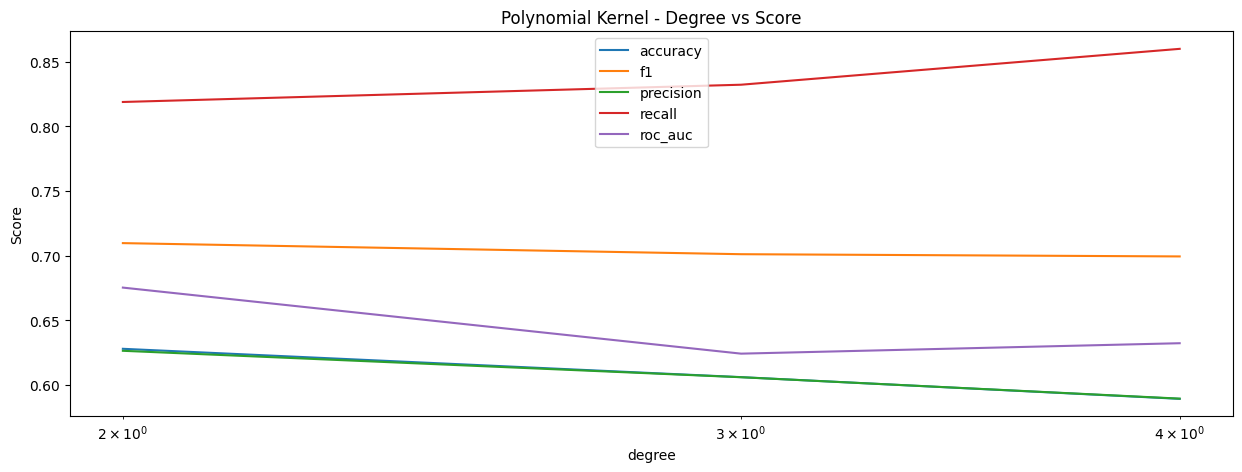

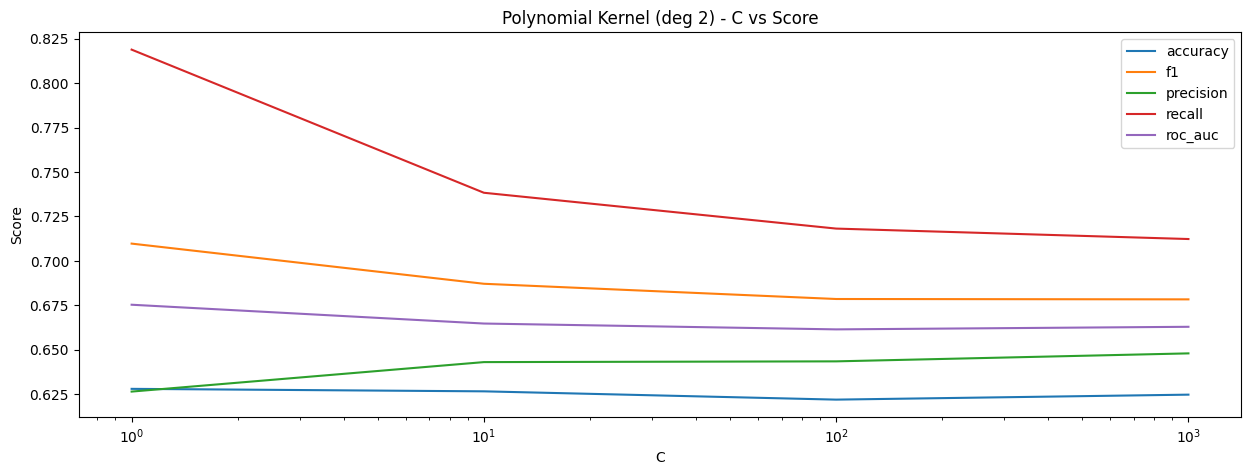

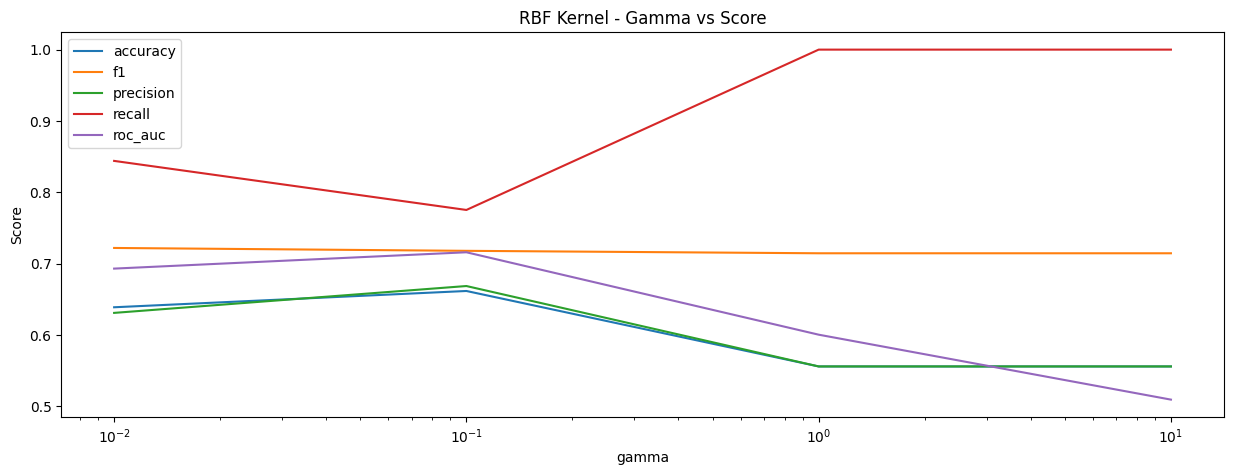

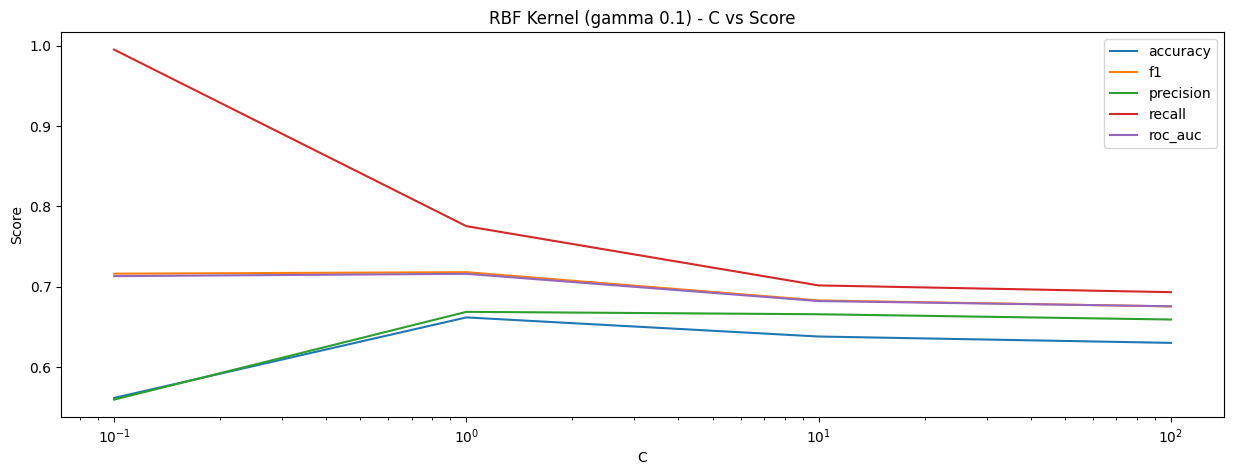

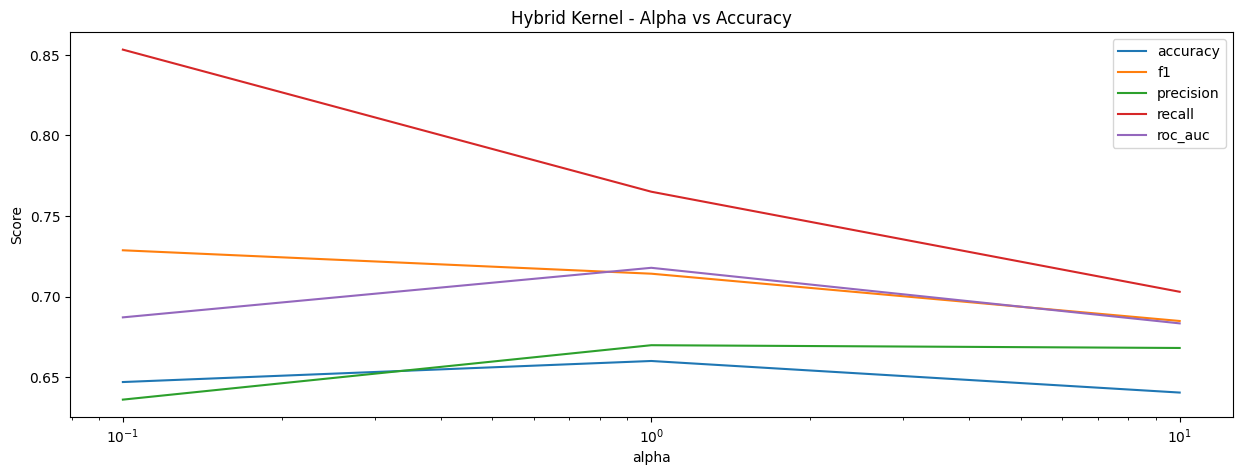

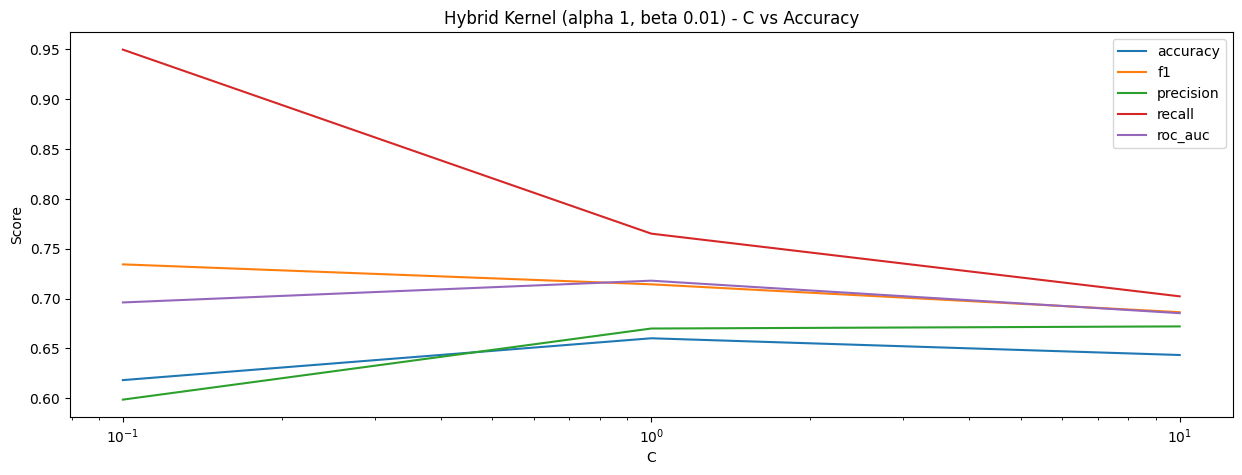

In [50]:
# plot the accuracy vs parameter graphs for different cv_results stored before

def plot_cv_results(cv_results, param_name, param_values, title):
    plt.figure(figsize=(15, 5))
    # print(cv_results)
    # print(param_values)
    for key in SCORING_METRICS:
        plt.plot(param_values, [result[f'mean_val_{key}'] for result in cv_results], label=key)

    plt.xscale('log')
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.title(title)
    plt.legend()
    plt.show()

# plot the results for the polynomial kernel
plot_cv_results(cv_results_poly, 'degree', [2, 3, 4], 'Polynomial Kernel - Degree vs Score')
plot_cv_results(cv_results_poly_c, 'C', [1, 10, 100, 1000], 'Polynomial Kernel (deg 2) - C vs Score')

# plot the results for the rbf kernel
plot_cv_results(cv_results_rbf_gamma, 'gamma', [0.01, 0.1, 1, 10], 'RBF Kernel - Gamma vs Score')
plot_cv_results(cv_results_rbf_c, 'C', [0.1, 1, 10, 100], 'RBF Kernel (gamma 0.1) - C vs Score')

# plot the results for the hybrid kernel for beta = 0.01
plot_cv_results(list(filter(lambda x: x["beta"] == 0.01, cv_results_hybrid)), 'alpha', [0.1, 1, 10], 'Hybrid Kernel - Alpha vs Accuracy')
plot_cv_results(cv_results_hybrid_c, 'C', [0.1, 1, 10], 'Hybrid Kernel (alpha 1, beta 0.01) - C vs Accuracy')

In [53]:
# Thus the best model is Hybrid, with alpha = 1, beta = 0.01, gamma = 0.16, C = 1.898
# With this model, we should apply SHAP, but since SHAP takes a lot of time, I will be using
# SVC with rbf kernel and the same gamma and c values, and also reduce input samples to 100

import shap

# Train the best model
best_model = SVC(random_state = RANDOM_STATE, kernel = 'rbf', gamma = 0.16, C = 1.898)
best_model.fit(X_train_small, y_train_small)

# Explain model prediction using SHAP
explainer = shap.Explainer(best_model.predict, X_train_small[:100])
shap_values = explainer(X_train_small[:100])

PermutationExplainer explainer: 101it [20:09, 12.10s/it]


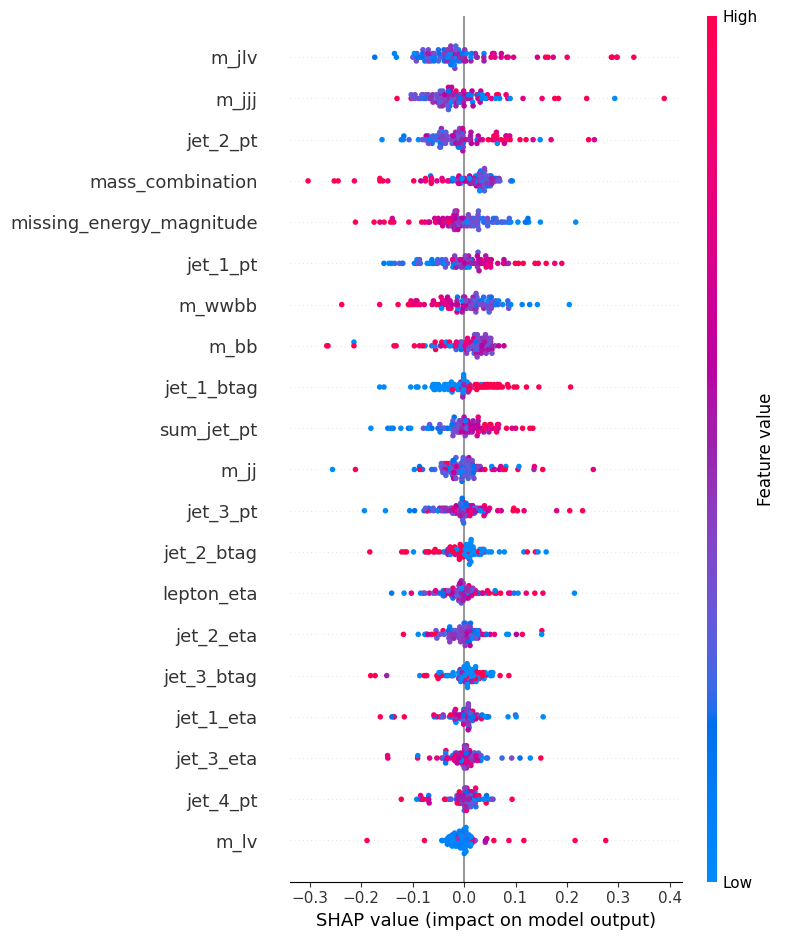

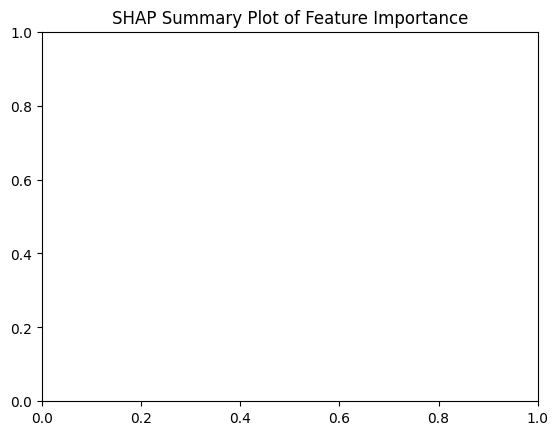

In [54]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train_small[:100], feature_names=list(selected_features))
plt.title("SHAP Summary Plot of Feature Importance")
plt.show()

In [57]:
rf_resultX = pd.DataFrame(shap_values.values, columns=list(selected_features))

vals = np.abs(rf_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(list(selected_features), vals)), columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
shap_importance

,col_name,feature_importance_vals
15,m_jlv,0.064746
13,m_jjj,0.053758
5,jet_2_pt,0.051992
19,mass_combination,0.050558
1,missing_energy_magnitude,0.050442
2,jet_1_pt,0.050413
17,m_wwbb,0.048337
16,m_bb,0.043683
4,jet_1_btag,0.040879
18,sum_jet_pt,0.039004
